In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl



%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

from shapely import geometry

import bresenham as bham

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
filename = '/Users/prakash/anaconda/envs/BobSeg/Data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
stack = imread(filename)
segchannel = stack[:,0,:,:]
flowchannel = stack[:,1,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)
print('Shape of stack:', stack.shape)
#shape(segchannel)[1]
print('Shape of flow channel:', flowchannel.shape)
print(len(flowchannel))

Shape of stack: (75, 2, 356, 610)
Shape of flow channel: (75, 356, 610)
75


In [3]:
t=1

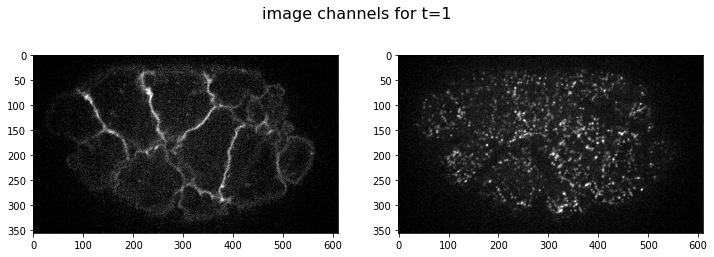

In [4]:
pylab.rcParams['figure.figsize'] = (12, 4)
fig = plt.figure()
fig.suptitle('image channels for t=%d'%t, fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(segchannel[t], plt.get_cmap('gray'))
ax = fig.add_subplot(122)
ax.imshow(flowchannel[t], plt.get_cmap('gray'))

In [5]:
def compute_flow( flowchannel ):
    flows = [None] * len(flowchannel)
    prvs = flowchannel[0]
    for f in range(flowchannel.shape[0]):
        nxt = flowchannel[f]
        flow = cv2.calcOpticalFlowFarneback(prev=prvs,
                                            next=nxt,
                                            flow=None,
                                            pyr_scale=0.5,
                                            levels=3,
                                            winsize=5,
                                            iterations=15,
                                            poly_n=5,
                                            poly_sigma=1.5,
                                            flags=1)
        flows[f] = flow
        prvs = nxt
        #print ('.')
    #print (' ...done!')
    return flows

In [6]:
flows = compute_flow( flowchannel );

In [7]:
shape(flows)

(75, 356, 610, 2)

In [8]:
flow_x = np.moveaxis(np.swapaxes(flows,0,3)[0],-1,0)
flow_y = np.moveaxis(np.swapaxes(flows,0,3)[1],-1,0)

flow_x_original = np.moveaxis(np.swapaxes(flows,0,3)[0],-1,0) # I am just keeping a copy of the original flows
flow_y_original = np.moveaxis(np.swapaxes(flows,0,3)[1],-1,0)

In [9]:
def flow_average(interval):
    ''' This function computes the average of the flows over a specified time interval. For example, if the time 
        interval is 5, it computes the average over a window of +5 and -5 for times where this window exists. 
        For times where one of the window doesn't exist, it just computes the average in the existing window. 
        Example: For time t = 43, the average is computed over t = 38 to t=48 for specified time interval 5. For 
         time t = 0, the averag eis only computed over t = 0 to t=5
    '''
    limit = len(flow_x)- interval
    for i in range(len(flow_x)):
        if (i< interval):
            flow_x[i] = np.average(flow_x[i:i+interval+1], axis=0)
            flow_y[i] = np.average(flow_y[i:i+interval+1], axis=0)
        elif (i> limit):
            print(i)
            flow_x[i] = np.average(flow_x[i-interval:], axis=0)
            flow_y[i] = np.average(flow_y[i-interval:], axis=0)
        else:
            flow_x[i] = np.average(flow_x[i-interval:i+interval+1], axis=0)
            flow_y[i] = np.average(flow_y[i-interval:i+interval+1], axis=0)
    return flow_x, flow_y

In [10]:
flow_x, flow_y = flow_average(5)

71
72
73
74


In [11]:
print(flow_x.shape)

(75, 356, 610)


In [12]:
max_rs = ((segchannel[0].shape[1] / 4),
          (segchannel[0].shape[1] / 4))

min_rs = (5,5)
print (min_rs, max_rs)

(5, 5) (152.5, 152.5)


In [13]:
data = Data3d( segchannel_smooth, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [14]:
cell = data.init_object("name your cell")
objects.append(cell)

In [15]:
data.add_object_at( cell, min_rs, max_rs, frame=0, seed=(460,250), segment_it=True )

#Finding center in each frame
moving_center = data.track(cell, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)
moving_center.insert(0, [460,250]) # Adds the first seed to list of centers

Added appearance for "name your cell" in frame 0 with seed coordinates [ 460.  250.]
      Optimum energy:  14.918549347501054
      Nodes in/out:  2940 4260
      Area:  13883.5
Added appearance for "name your cell" in frame 1 with seed coordinates [ 460.  250.]
      Optimum energy:  14.323638128637842
      Nodes in/out:  2928 4272
      Area:  13839.5
    Updated center to [ 447.83333333  240.125     ]
Added appearance for "name your cell" in frame 2 with seed coordinates [ 448.  240.]
      Optimum energy:  16.71019222523085
      Nodes in/out:  3077 4123
      Area:  14209.5
    Updated center to [ 442.98611111  232.94444444]
Added appearance for "name your cell" in frame 3 with seed coordinates [ 443.  233.]
      Optimum energy:  18.962582046438985
      Nodes in/out:  3067 4133
      Area:  13785.0
    Updated center to [ 441.33333333  229.33333333]
Added appearance for "name your cell" in frame 4 with seed coordinates [ 441.  229.]
      Optimum energy:  18.673586977481392
  

      Optimum energy:  18.410712071754062
      Nodes in/out:  2816 4384
      Area:  11509.5
    Updated center to [ 438.54166667  227.77777778]
Added appearance for "name your cell" in frame 39 with seed coordinates [ 439.  228.]
      Optimum energy:  17.95419404175173
      Nodes in/out:  2808 4392
      Area:  11485.0
    Updated center to [ 439.04166667  226.88888889]
Added appearance for "name your cell" in frame 40 with seed coordinates [ 439.  227.]
      Optimum energy:  17.423204466373573
      Nodes in/out:  2783 4417
      Area:  11227.5
    Updated center to [ 439.79166667  226.55555556]
Added appearance for "name your cell" in frame 41 with seed coordinates [ 440.  227.]
      Optimum energy:  17.405891935165226
      Nodes in/out:  2768 4432
      Area:  11124.0
    Updated center to [ 440.83333333  225.44444444]
Added appearance for "name your cell" in frame 42 with seed coordinates [ 441.  225.]
      Optimum energy:  16.02517030488404
      Nodes in/out:  2769 4431
 

### Finding points on surface/ interior contour parallel to membrane returned by Netsurface. The description of the variables returned by the following cell is below

1) surface_coords is a dictionary where each key returns a list of surface points of the membrane returned by Netsurface for one time point. For example: surface_coords[0] returns a list of surface points of the membrane returned by Netsurface for t = 0.

2) surface_coords_interior1 is a dictionary where each key returns a list of surface points of a contour parallel to the membrane at a certain distance inside the actual membrane for one time point. 

3) surface_coords_interior_last is a dictionary where each key returns a list of surface points of a contour parallel to the membrane at a certain distance inside the actual membrane for one time point.

Thus, surface_coords_interior1 and surface_coords_interior_last define a annulus of certain width inside the actual membrane.

In [16]:
surface_coords, surface_coords_interior1, surface_coords_interior_last = data.segment2dt( cell, max_radial_delta=2 )

Surface points: [(506, 250), (509, 254), (502, 257), (506, 262), (509, 267), (512, 274), (512, 280), (510, 285), (507, 290), (501, 291), (495, 292), (491, 295), (484, 292), (480, 294), (478, 301), (474, 304), (468, 299), (464, 304), (460, 306), (455, 306), (449, 311), (444, 307), (439, 305), (432, 309), (427, 306), (421, 304), (415, 303), (409, 300), (401, 298), (395, 295), (391, 289), (392, 281), (394, 273), (396, 266), (399, 260), (399, 255), (404, 250), (405, 245), (410, 241), (411, 236), (406, 230), (414, 228), (413, 223), (411, 215), (415, 212), (414, 204), (415, 196), (416, 187), (419, 179), (422, 170), (429, 164), (436, 162), (443, 155), (451, 149), (460, 155), (468, 158), (477, 153), (484, 159), (489, 167), (494, 175), (497, 184), (501, 190), (503, 198), (503, 206), (503, 213), (501, 220), (498, 227), (499, 231), (497, 236), (497, 239), (499, 242), (500, 246)]
Interior points: [(493, 250), (495, 253), (489, 255), (493, 258), (496, 263), (500, 268), (501, 273), (499, 277), (497,

      Area:  13483.5
Surface points: [(489, 223), (489, 227), (488, 231), (492, 237), (492, 242), (492, 248), (493, 254), (492, 260), (493, 268), (490, 274), (485, 278), (478, 280), (470, 278), (466, 282), (461, 284), (456, 287), (450, 288), (444, 289), (438, 294), (432, 291), (427, 288), (420, 290), (416, 284), (411, 281), (407, 277), (399, 279), (393, 277), (384, 277), (375, 276), (369, 271), (369, 263), (371, 254), (374, 246), (378, 239), (383, 232), (388, 227), (392, 223), (397, 219), (399, 215), (399, 212), (399, 208), (399, 204), (400, 200), (399, 195), (401, 191), (403, 187), (405, 183), (405, 175), (406, 167), (409, 159), (413, 153), (418, 145), (423, 138), (430, 131), (438, 136), (445, 143), (451, 149), (457, 152), (464, 151), (468, 159), (473, 163), (480, 163), (485, 167), (488, 173), (487, 181), (487, 188), (491, 192), (490, 199), (490, 204), (490, 209), (490, 213), (489, 218)]
Interior points: [(476, 223), (476, 226), (475, 229), (479, 233), (479, 237), (480, 242), (481, 24

The cell below computes the bresenham points between two points on each ray and stores them in a dictionary called bresenham_dict. This data is in turn stored in a bigger dictionary called big_bresenham_dict which stores such data for all time points. 
For example, for time 't' , the bresenham coordinates of the points on ray 'r' can be obtained by 
big_bresenham_dict[t][r]


In [17]:
big_bresenham_dict = {} #For storing all bresenham points for all time points
#Its size will be (no.of time frames)x(no.of rays/columns)x(len(bresenham points in each ray/column))
 
for f in range(flowchannel.shape[0]):
    
    bresenham_dict = {} #For finding bresenham points between points on membrane and interior on each ray      
    for i in range(len(surface_coords_interior1[0])):
               
        bresenham_dict[i] = bham.bresenhamline(np.array([(surface_coords_interior1[f][i])]), np.array([(surface_coords_interior_last[f][i])]))
                
    big_bresenham_dict[f] = bresenham_dict

Next, we wil initialize some imaginary myosins/update points and track them over time using flows that we have.
The following few cells define some functions which will be needed to do this.

In [18]:
def euclid_dist(x,y):
    '''Computing euclidean distance between two points 
    '''
    distance = ((y[0]-x[0])**2+(y[1]-x[1])**2)**.5
    return distance

In [19]:
def neighbors(curr_pos):
    '''Finding neighbors of the point 'curr_pos' in a 8-neighborhood grid. Each point is a neighbor of itself too.
    '''
    neighbor = [(curr_pos[0], curr_pos[1]), (curr_pos[0]-1, curr_pos[1]), (curr_pos[0], curr_pos[1]-1), (curr_pos[0]+1, curr_pos[1]), (curr_pos[0], curr_pos[1]+1), (curr_pos[0]-1, curr_pos[1]+1), (curr_pos[0]+1, curr_pos[1]+1),(curr_pos[0]-1, curr_pos[1]-1), (curr_pos[0]+1, curr_pos[1]-1)]
    return neighbor

In [20]:
def neighbor_flow(neighbor,f):
    '''Finds the flow at neighbors
    '''
    l = len(neighbor)
    neigh_flow_x = [None]*l
    neigh_flow_y = [None]*l
    for i in range(l):
        neigh_flow_x[i] = flow_x[f,neighbor[i][1], neighbor[i][0]]
        neigh_flow_y[i] = flow_y[f,neighbor[i][1], neighbor[i][0]]
    return neigh_flow_x, neigh_flow_y

In [21]:
def pixel_pos(neighbor, neigh_flow_x, neigh_flow_y, sub_pix_pos):
    '''Interpolated flows at possibly sub-pixel loactions
    '''
    evaluate_at = (sub_pix_pos)
    result_x = griddata(neighbor, neigh_flow_x, evaluate_at, method = 'cubic')
    result_y = griddata(neighbor, neigh_flow_y, evaluate_at, method = 'cubic')
    
    return result_x, result_y

In [22]:
def update_pos(img_myo, f):
    '''Updated position after interpolation
    '''
    grid_x = int(img_myo[0])
    grid_y = int(img_myo[1])
    neighbor = neighbors((grid_x,grid_y))
    neigh_flow_x, neigh_flow_y = neighbor_flow(neighbor,f)
    result_x, result_y = pixel_pos(neighbor, neigh_flow_x, neigh_flow_y, img_myo)
    new_pos_x = img_myo[0]+result_x
    new_pos_y = img_myo[1]+result_y
    seed_img_myo=(new_pos_x, new_pos_y)
    
    return seed_img_myo

Now, the imaginary myosins/update points need to be initialized somewhere inside the membrane. The question is how to pick these positions. We have tried the following two ways:

Method 1- Pick points on a contour inside the actual membrane. For example the set of points returned by surface_coords_interior1 for say, time frame t=0. These can be the initial imaginary myosin positions.

Method 2- Pick all the points on the bresenham line between two contours inside the actual membrane. For example, all the bresenahm points between surface_coords_interior1 and surface_coords_interior_last for say, time frame t =0.

We have also made another variable called 'time'(in the next cell) which specifies from which time frame the initial points for imaginary myosin to be chosen.  

In [23]:
time = 15

In [24]:
#use the following line only for getting points on a single membrane contour-> method 1
#initial_myo_pos = list(surface_coords_interior1[time]) 


# Use the following code only for getting all points between two interior membrane contours on all rays-> method 2
initial_myo = [] # List which stores initial points of all imaginary myosins
new_myo = []
for i in range(len(big_bresenham_dict[time])):
    for j in range(len(big_bresenham_dict[time][i])):
        initial_myo.append(big_bresenham_dict[time][i][j]) 

startList=[]
for i in range(len(initial_myo)):
    startList.append(initial_myo[i].tolist())
    
initial_myo_pos = []
for ele in startList:
     initial_myo_pos.append(tuple(ele))
#

In [25]:
print(len(initial_myo_pos)) # To check how many imaginary myosins/update points were chosen.

1434


In [26]:
# The following is a dictionary in which each key stores the positions of one imaginary myosin over all time frames. 
#There can be multiple keys (depending on len(initial_myo_pos)) and hence multiple imaginary myosins can be tracked over time.
big_dict = {}

In [27]:
# Tracking imaginary myosin/update points over time

for i in range(len(initial_myo_pos)):
    
    myo_pos = [None]*(len(segchannel)-time)
    myo_pos[0] = initial_myo_pos[i]
    img_myo = myo_pos[0]
    
    for j in range(time,len(segchannel),1):
        
        f=j
        
        seed_img_myo = update_pos(img_myo, f)
        img_myo = seed_img_myo
        myo_pos[j-time] = seed_img_myo
    
    myo_pos.insert(0,initial_myo_pos[i]) # Insert the starting position to the zeroth index
    big_dict[i] = myo_pos 

In [28]:
cumulative_myosin_dist = []
cumulative_membrane_dist = []

for frame in range(time,len(segchannel),1):
    myosin_dist_from_center = 0
    membrane_dist_from_center = 0
    
    for i in range(len(initial_myo_pos)):
        dist2 = euclid_dist(big_dict[list(big_dict)[i]][frame-time], moving_center[frame])
        myosin_dist_from_center = dist2 + myosin_dist_from_center
        
    cumulative_myosin_dist.append(myosin_dist_from_center)    
    
    for j in range(len(surface_coords_interior1[0])):
        
        dist1 = euclid_dist(surface_coords[frame][j], moving_center[frame])
        membrane_dist_from_center = membrane_dist_from_center+dist1
          
    cumulative_membrane_dist.append(membrane_dist_from_center)

In [29]:
#Number crunching for plots
flow_movement_factor_list = []
membrane_movement_factor_list = []

for i in range(len(cumulative_myosin_dist)-1):
    flow_movement_factor = cumulative_myosin_dist[i+1]/cumulative_myosin_dist[i]
    flow_movement_factor_list.append(flow_movement_factor)
    membrane_movement_factor = cumulative_membrane_dist[i+1]/cumulative_membrane_dist[i]
    membrane_movement_factor_list.append(membrane_movement_factor)


In [30]:
print(cumulative_membrane_dist) # To see how the membrane distance from center decreases over time

[4531.1807523921507, 4476.9660812433558, 4463.5663084199296, 4425.6240470457451, 4488.6078308270316, 4524.7616429044419, 4554.9190446797738, 4590.7613698540063, 4629.5986137021355, 4600.1592156585984, 4618.7414132119748, 4587.7448595932156, 4500.6871456951094, 4450.2155501361485, 4426.8614735602123, 4344.2674551622813, 4343.6493365172018, 4311.2671748715065, 4280.0735058076625, 4298.0156028212668, 4270.901177581477, 4262.2057956280969, 4303.334723026871, 4317.7173635079716, 4301.9189923562662, 4290.6813115317536, 4264.1582242597924, 4217.4513470945385, 4201.3290544184465, 4181.290314484816, 4200.9437181832845, 4232.0488876581148, 4279.1712843236965, 4330.0888482904511, 4346.8958890663689, 4354.0726449110725, 4310.5588666870508, 4291.0333885926821, 4307.6226914418994, 4328.4335974648075, 4353.4336561126374, 4366.0903317949223, 4354.9362689919644, 4274.0107389662398, 4169.5292075245206, 4082.2366817574648, 4038.2291544229306, 4011.3406270841701, 3953.4493886564487, 3896.2103863237276, 38

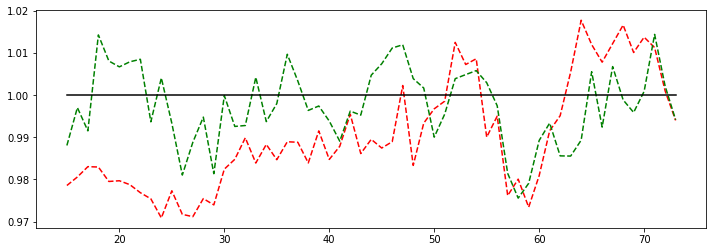

In [31]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(time, len(flowchannel)-1, 1.)
plt.plot(t, flow_movement_factor_list, 'r--',t, membrane_movement_factor_list, 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

In [32]:
#In this cell, we will compute the Pearosn Correlation Coefficient for 
#the two curves in the above figure to make more sense oput of the curves.
corr_new = []
for start in range(0,len(flow_movement_factor_list)-15,1):
    new_c,new_p = pearsonr(flow_movement_factor_list[start:], membrane_movement_factor_list[start:])
    print('start: ', start+time, '; ','till ',len(segchannel), new_c, new_p)
    corr_new.append(new_c)

start:  15 ;  till  75 0.276226240265 0.0341978764772
start:  16 ;  till  75 0.264080698078 0.0451652775576
start:  17 ;  till  75 0.264523501229 0.0467632196164
start:  18 ;  till  75 0.259202251417 0.0537241780921
start:  19 ;  till  75 0.288830376715 0.032465316614
start:  20 ;  till  75 0.314485590052 0.020557363671
start:  21 ;  till  75 0.338071551015 0.013290560711
start:  22 ;  till  75 0.369159417868 0.00707721624413
start:  23 ;  till  75 0.410195849374 0.00279399099343
start:  24 ;  till  75 0.408562063518 0.00322294488193
start:  25 ;  till  75 0.452171646844 0.00110734491048
start:  26 ;  till  75 0.450400718576 0.00131682295694
start:  27 ;  till  75 0.413872503146 0.00382958042566
start:  28 ;  till  75 0.395106662441 0.00657685828898
start:  29 ;  till  75 0.396575338683 0.00699621311702
start:  30 ;  till  75 0.351371278631 0.0193480505534
start:  31 ;  till  75 0.36309528754 0.0167055839428
start:  32 ;  till  75 0.355745259456 0.0207707485057
start:  33 ;  till  75 0

Text(0,0.5,'correlation')

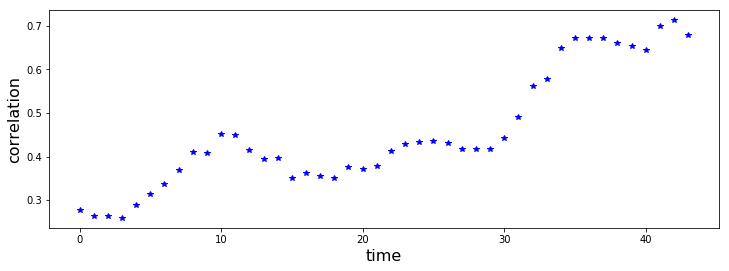

In [33]:
pyplot.plot(corr_new, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

### Next we want to see if the initial points which we chose for our imaginary myosins are inside the actual cell membrane or not for all time frames. This is good for visual debugging.   

In [34]:
def border_comp(time_frame):
    ''' Draws the border of the membrane returned by Netsurf and the border obtained by update
        points/imaginary myosins for visualization
    '''
    polygon1 = geometry.Polygon(surface_coords[time_frame])
    poly = []
    for i in range(len(initial_myo_pos)):
        poly.append(big_dict[list(big_dict)[i]][time_frame-time])
    #print('Imaginary myosin created contour:',poly)
    polygon2= geometry.Polygon(poly)
    polygon3 = geometry.Polygon(surface_coords_interior1[time_frame])
    polygon4 = geometry.Polygon(surface_coords_interior_last[time_frame])
   
    x1,y1 = polygon1.exterior.xy
    x2,y2 = polygon2.exterior.xy
    x3,y3 = polygon3.exterior.xy
    x4,y4 = polygon4.exterior.xy
    
    return x1,y1,x2,y2,x3,y3,x4,y4

In [35]:
start_frame = time
end_frame = len(segchannel)

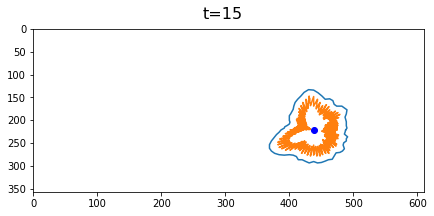

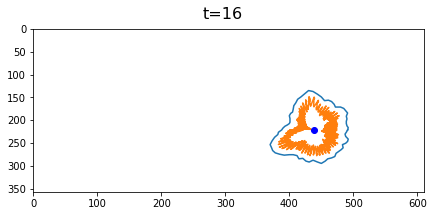

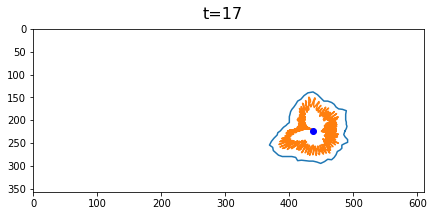

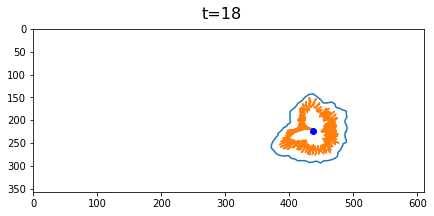

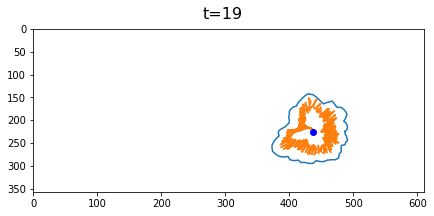

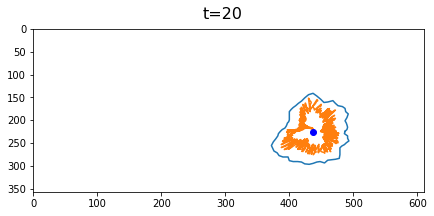

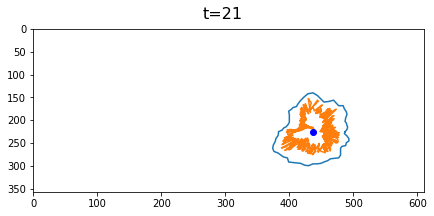

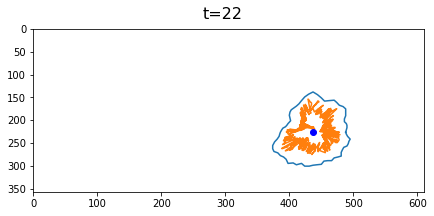

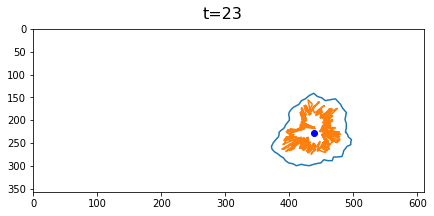

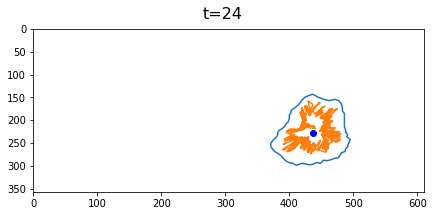

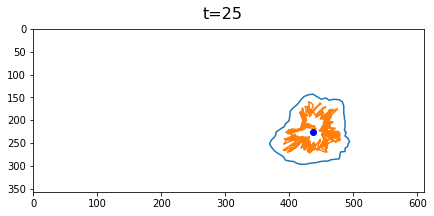

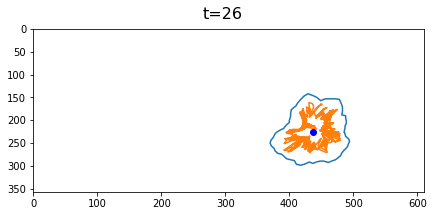

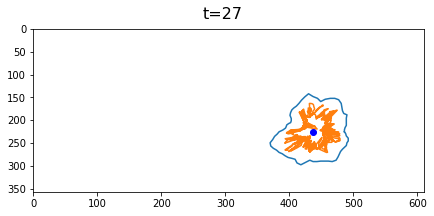

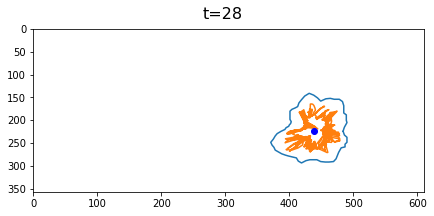

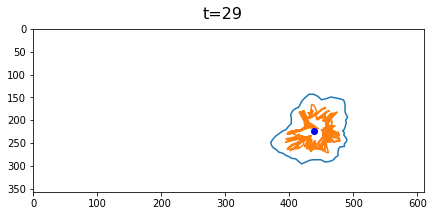

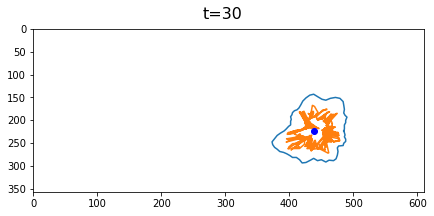

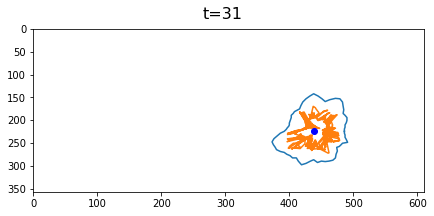

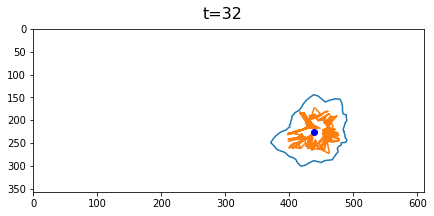

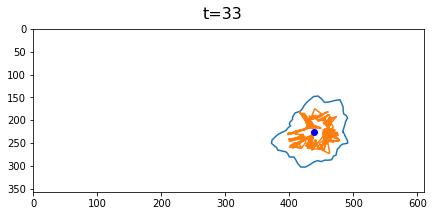

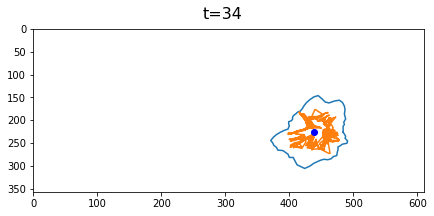

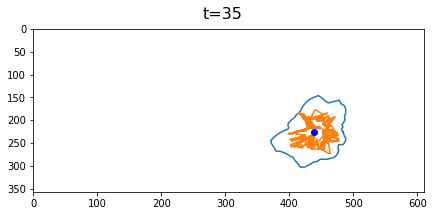

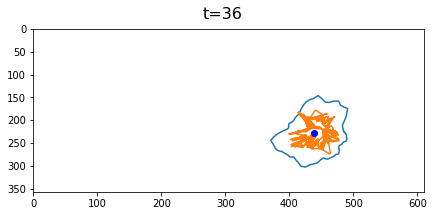

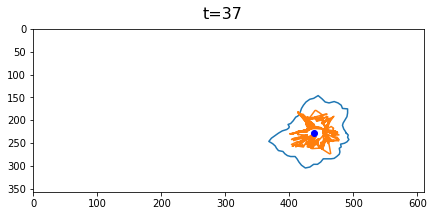

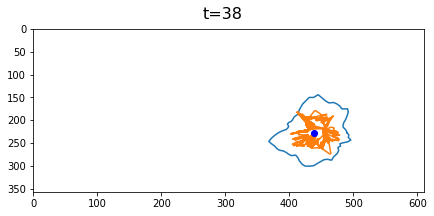

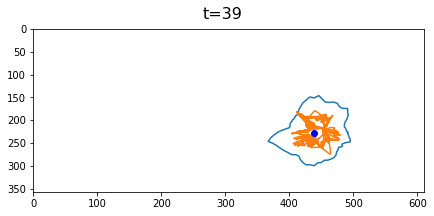

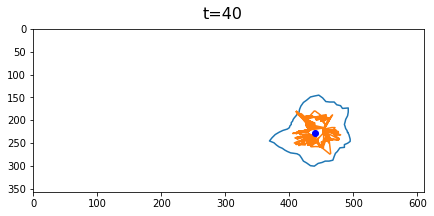

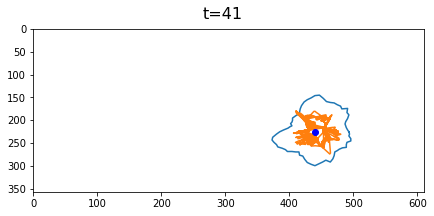

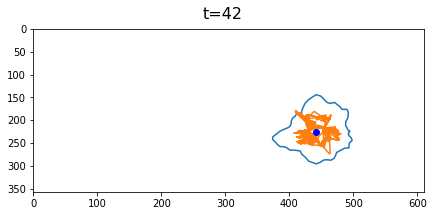

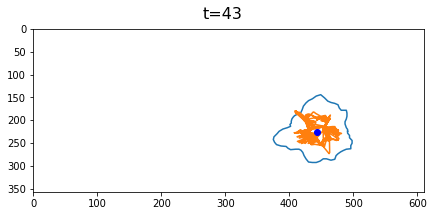

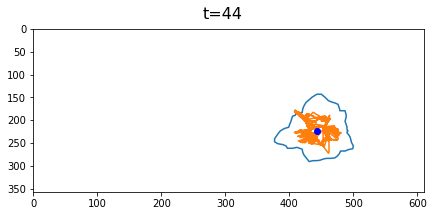

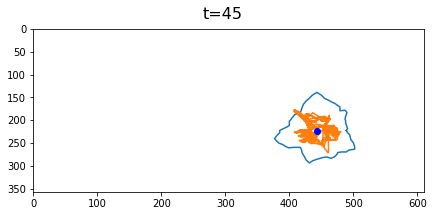

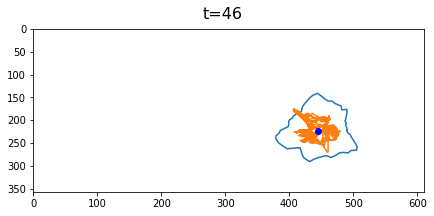

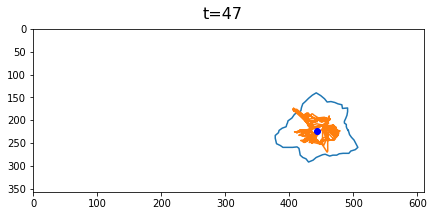

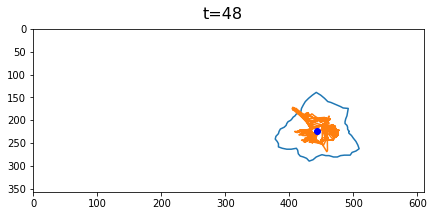

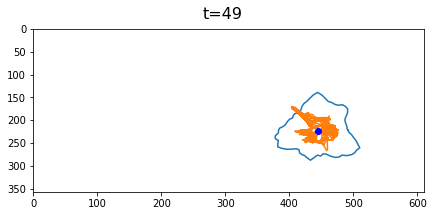

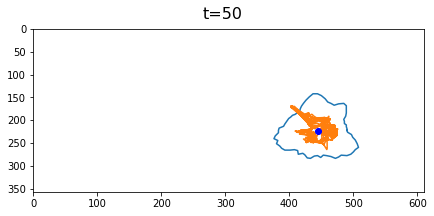

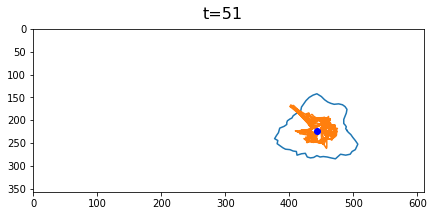

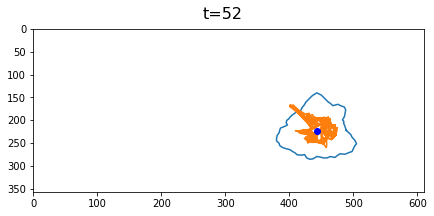

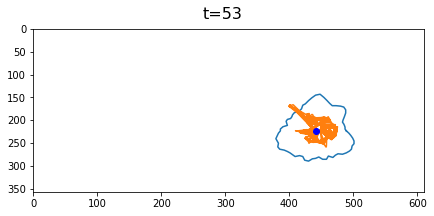

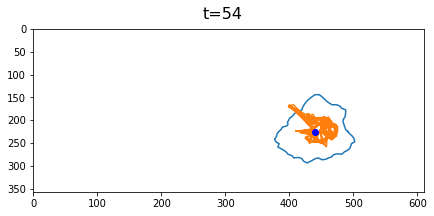

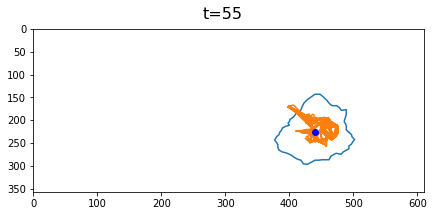

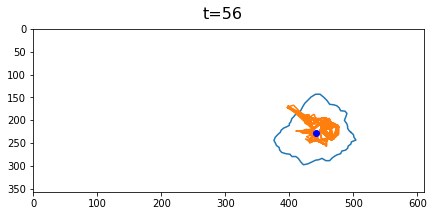

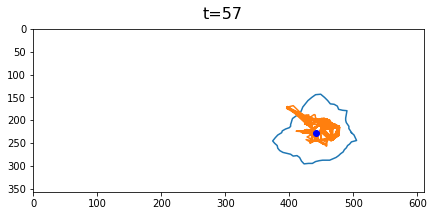

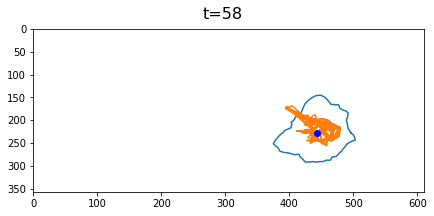

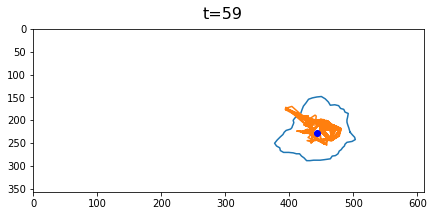

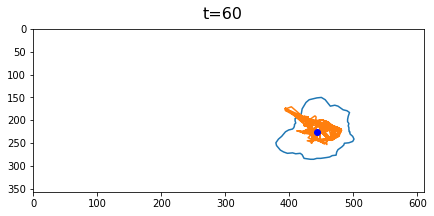

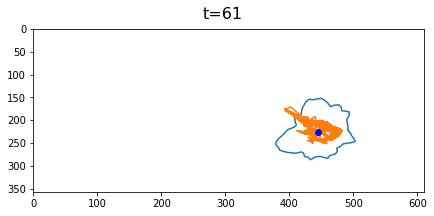

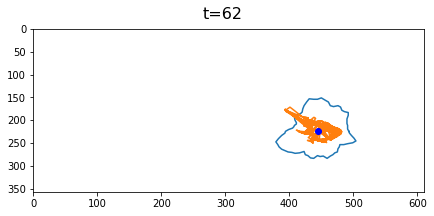

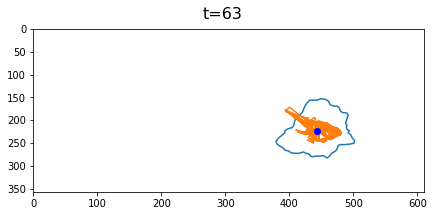

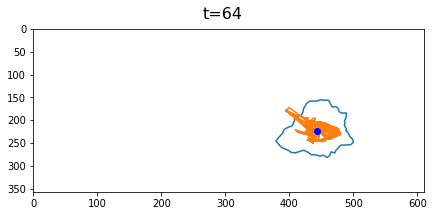

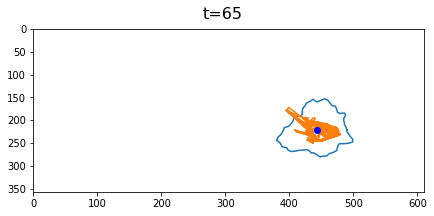

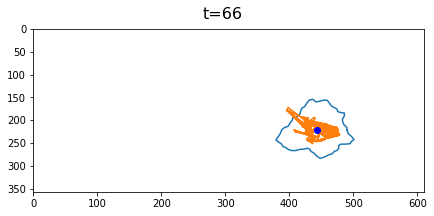

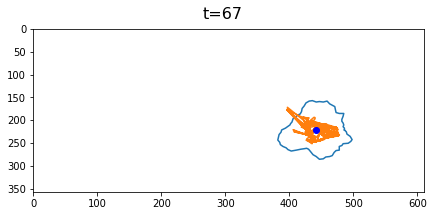

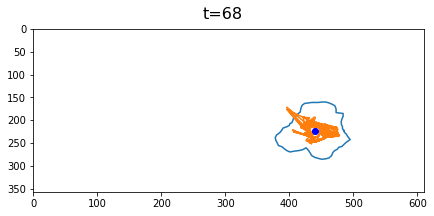

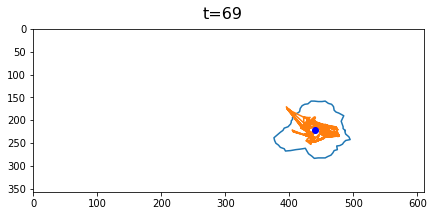

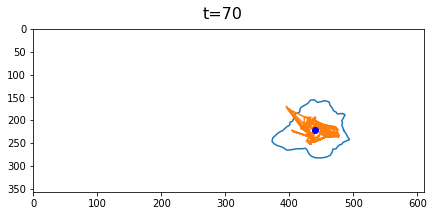

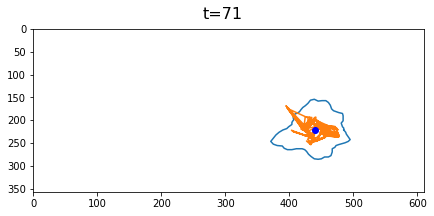

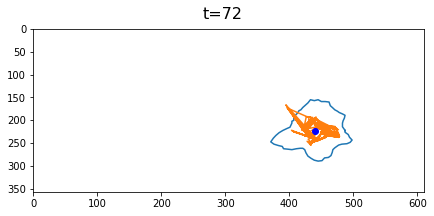

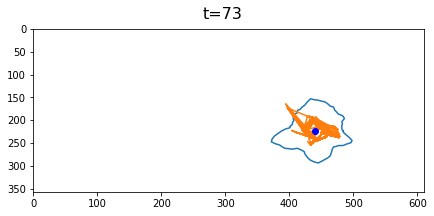

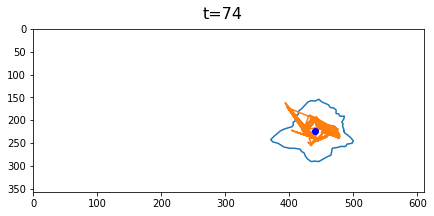

In [36]:
# Plotting borders for the actual membrane and the positions of all the imaginary myosins
for i in range(start_frame, end_frame, 1):
    
    membrane_x, membrane_y, myosin_x, myosin_y, first_interior_x, first_interior_y, last_interior_x, last_interior_y = border_comp(i)
    pylab.rcParams['figure.figsize'] = (7, 3)
    pylab.ylim([flowchannel.shape[1],0])
    pylab.xlim([0,flowchannel.shape[2]])
    plt.suptitle('t=%d'%i, fontsize=16)
    plt.plot(membrane_x, membrane_y)
    plt.plot(myosin_x, myosin_y)
    plot(moving_center[i][0],moving_center[i][1], 'bo')
    #plt.plot(first_interior_x, first_interior_y)
    #plt.plot(last_interior_x, last_interior_y)
    plt.show()

In [37]:
def get_projected_length(vector, vec2project):
    '''
    Projects one vector onto another and returns the projected length.
    vector      - (x,y)-tuple to project on
    vec2project - (x,y)-tuple that should be projected onto given vector
    '''
    flow_x = vec2project[0]
    flow_y = vec2project[1]
    dx = vector[0]
    dy = vector[1]
    len_vector = math.sqrt(dx**2+dy**2)
    return (flow_x*dx + flow_y*dy)/len_vector

In [38]:
def new_movie(frame):
    
    '''This function computes the average flow along each ray 
       (by averaging flows on all bresenham points between the two interior membrane contours)
       for the time frame specified by the argument 'frame'
    '''
    
    avg_rayflow_x = []
    avg_rayflow_y = []
    
    for ray in range(len(big_bresenham_dict[0])):
            
        average_flow_x = 0
        average_flow_y = 0
        
        for point in range(len(big_bresenham_dict[frame][ray])):
            
            average_flow_x += flow_x[frame][big_bresenham_dict[frame][ray][point][1]][big_bresenham_dict[frame][ray][point][0]]
            average_flow_y += flow_y[frame][big_bresenham_dict[frame][ray][point][1]][big_bresenham_dict[frame][ray][point][0]]
            
        avg_rayflow_x.append(average_flow_x/len(big_bresenham_dict[frame][ray]))
        avg_rayflow_y.append(average_flow_y/len(big_bresenham_dict[frame][ray]))
        
    return avg_rayflow_x, avg_rayflow_y
            

In the following cells, we plot the average flows computed by the above function for each ray and for each time frame. 
We draw the actual membrane outline as returned by Netsurface in blue, the first interior contour in orange and the second interior contour in green. We plot the averge flows on the mid point of the rays joining the first and the second interior contours. The length of the arrows represent the magnitude of the averge flows on that ray.

In [39]:
start_movie = time 
end_movie = len(segchannel)

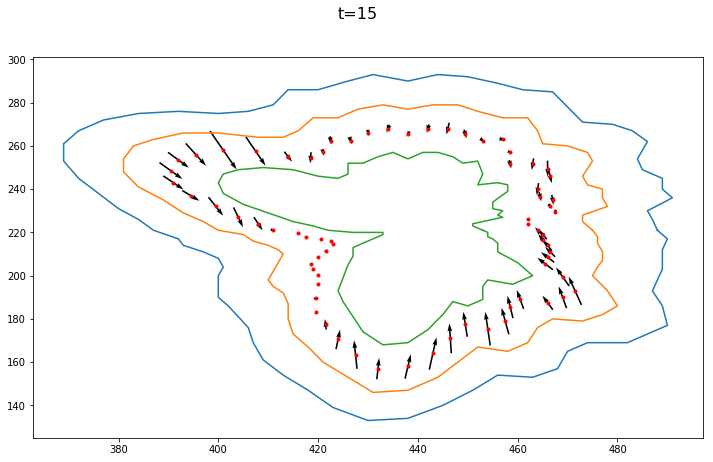

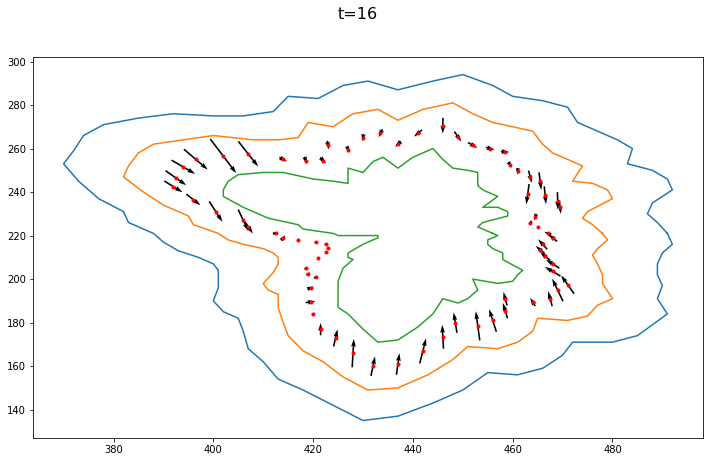

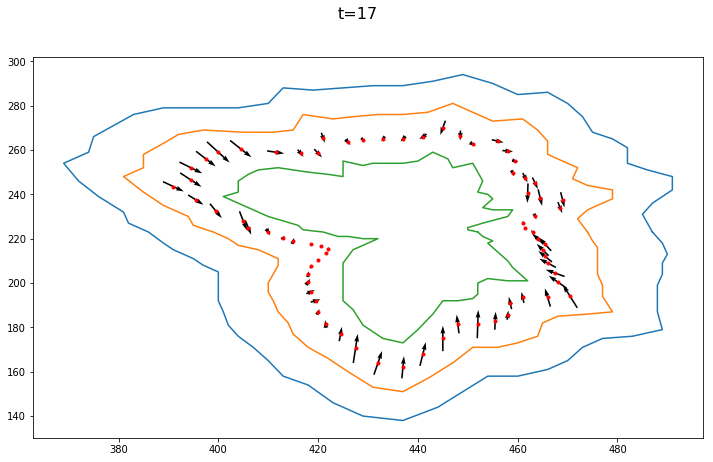

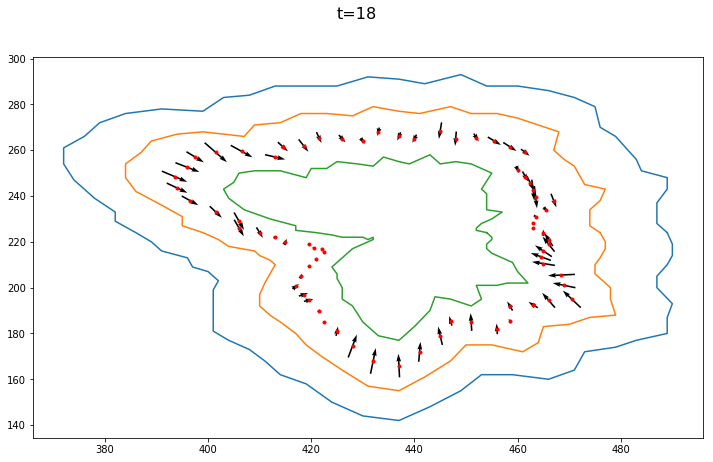

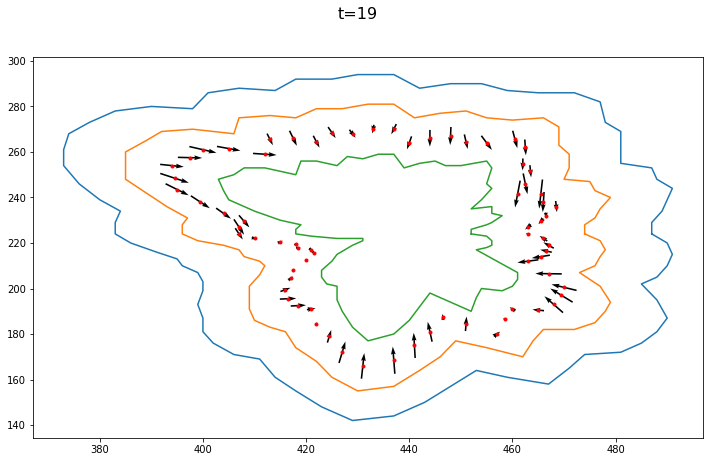

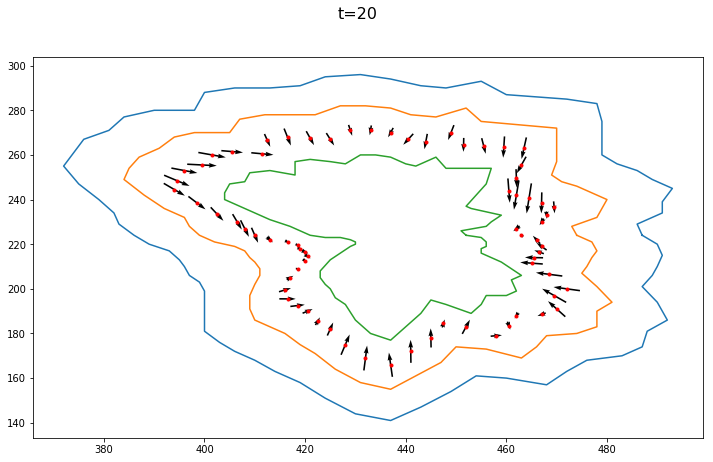

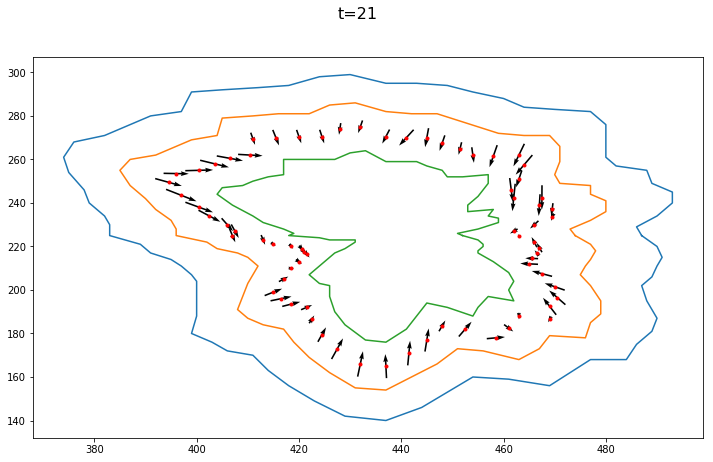

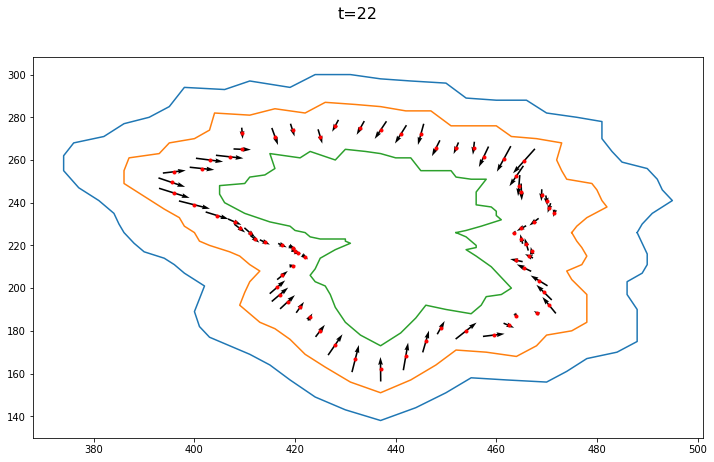

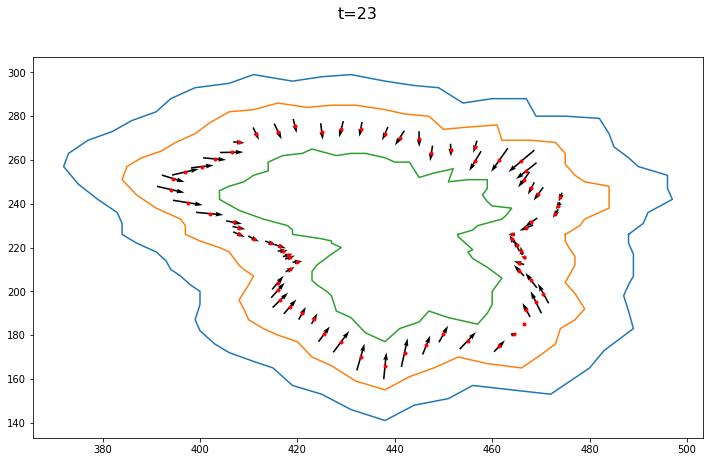

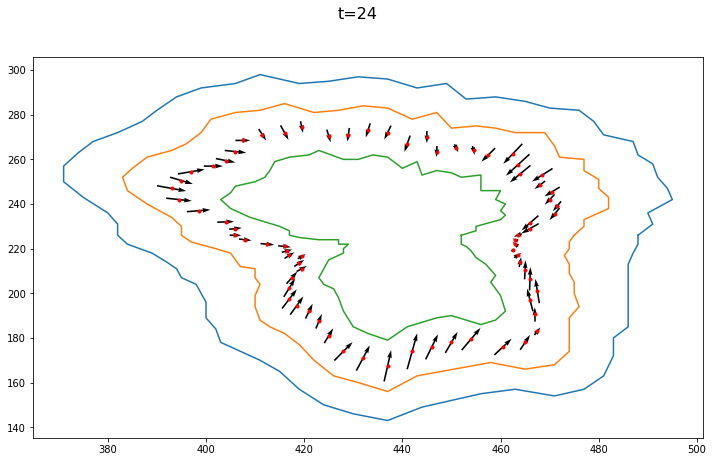

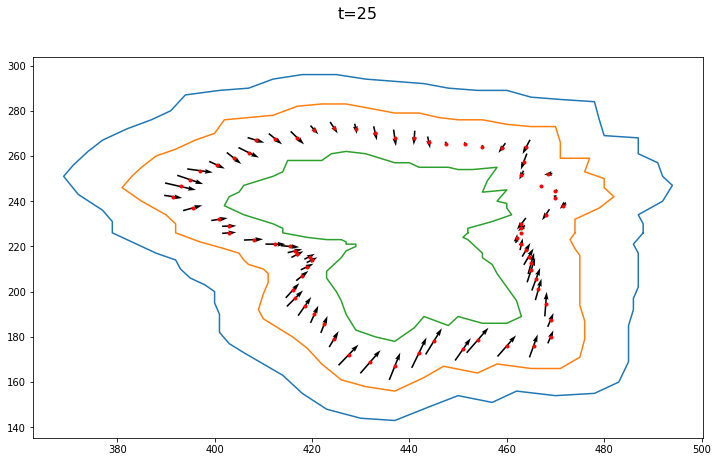

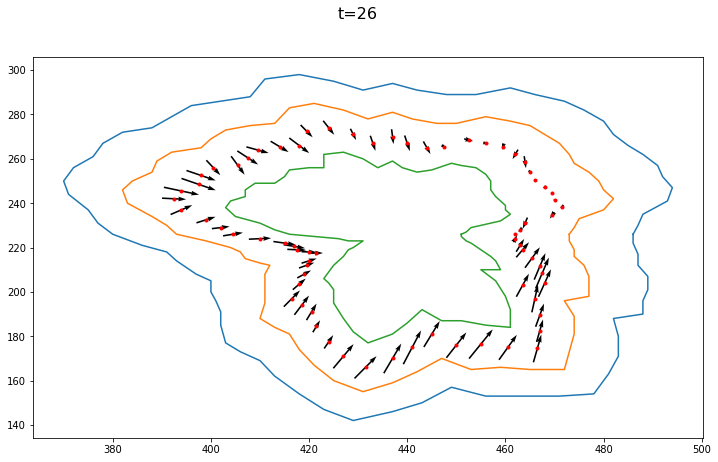

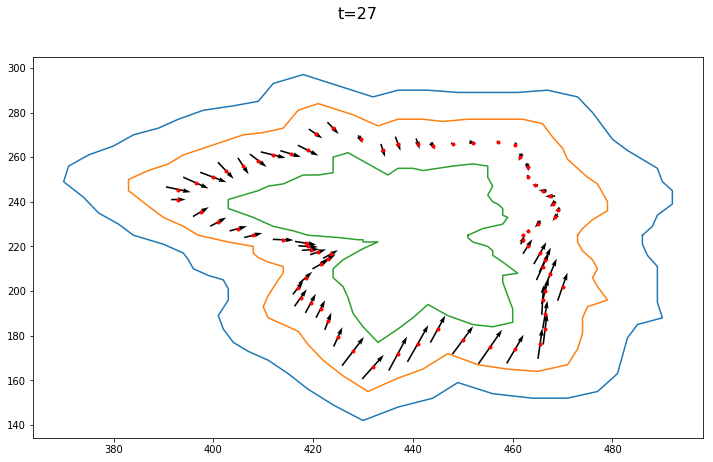

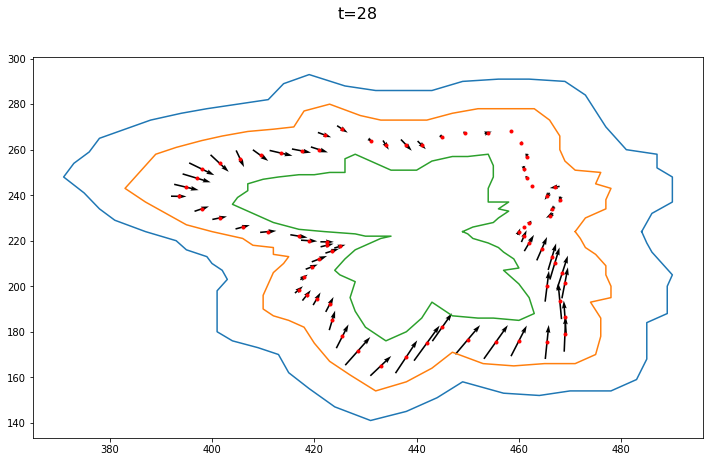

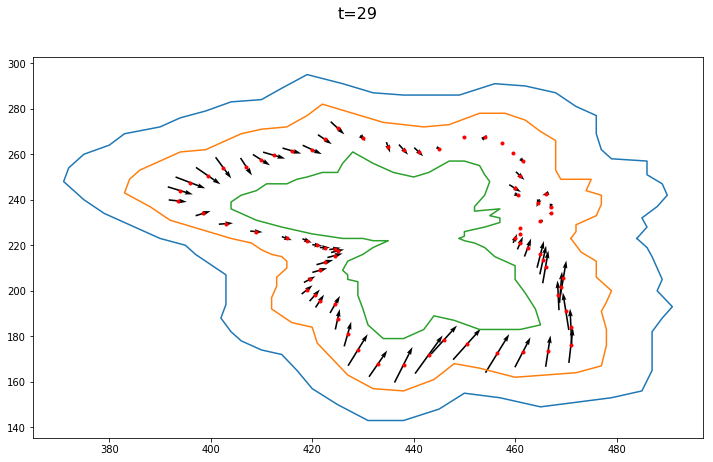

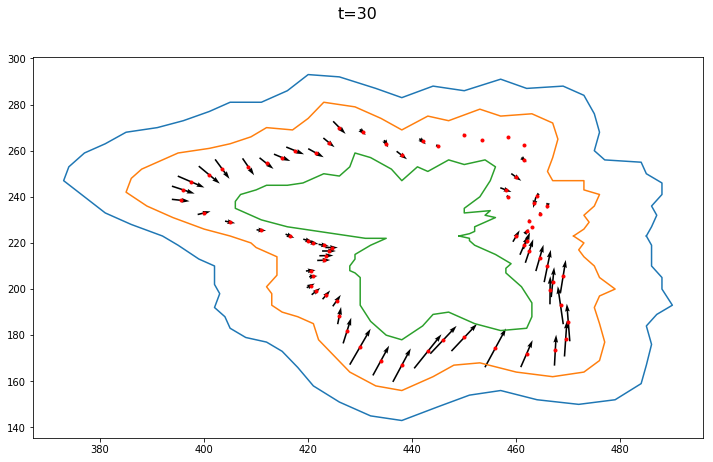

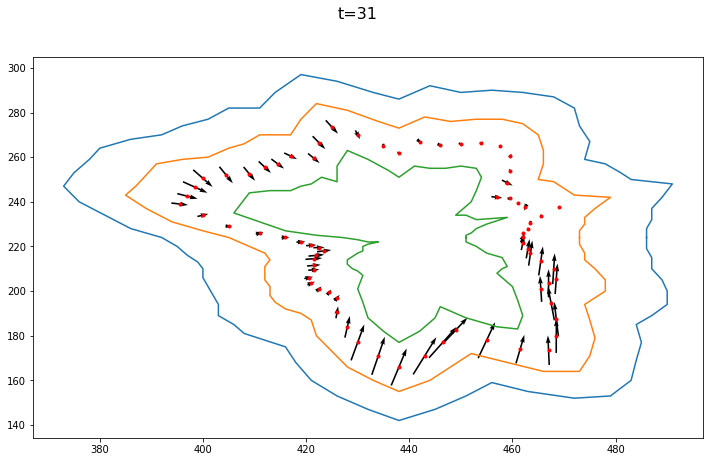

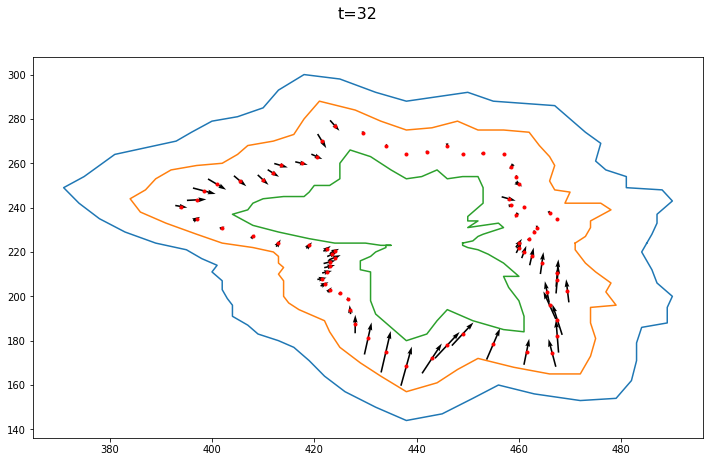

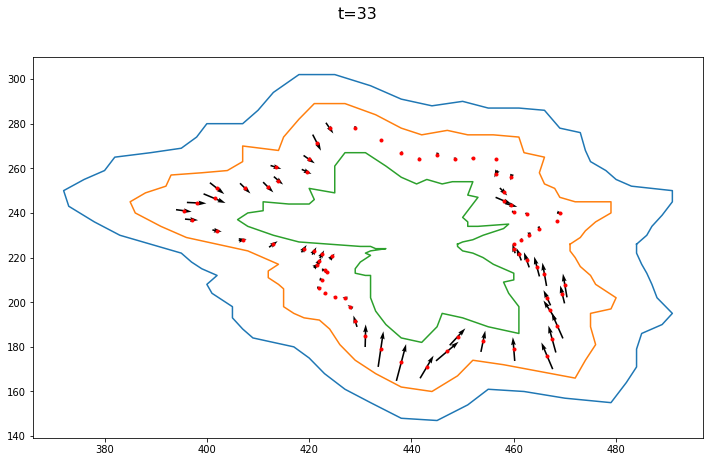

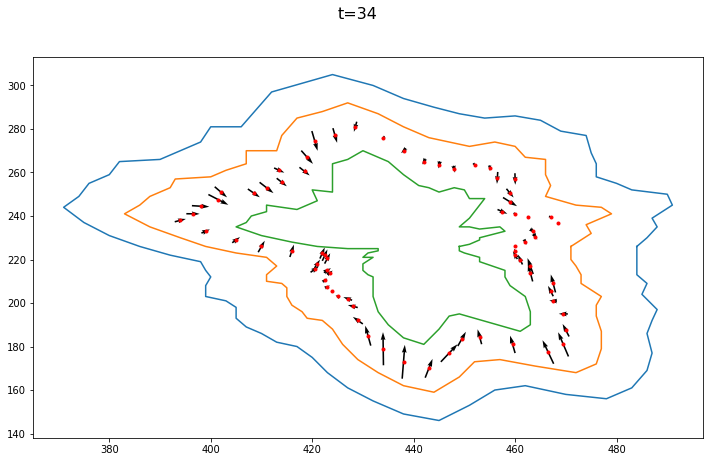

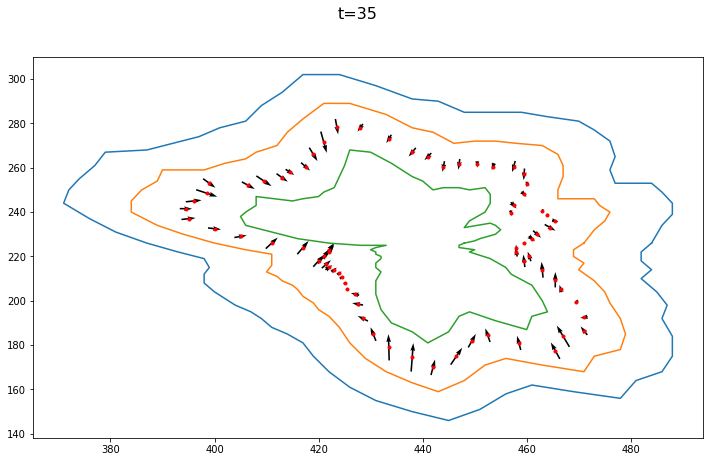

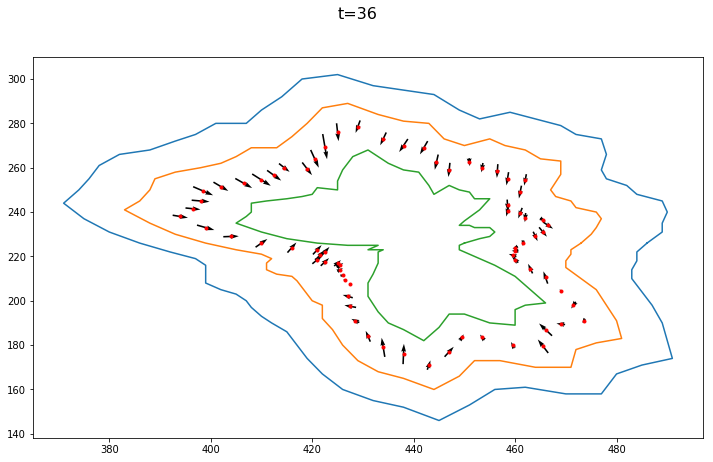

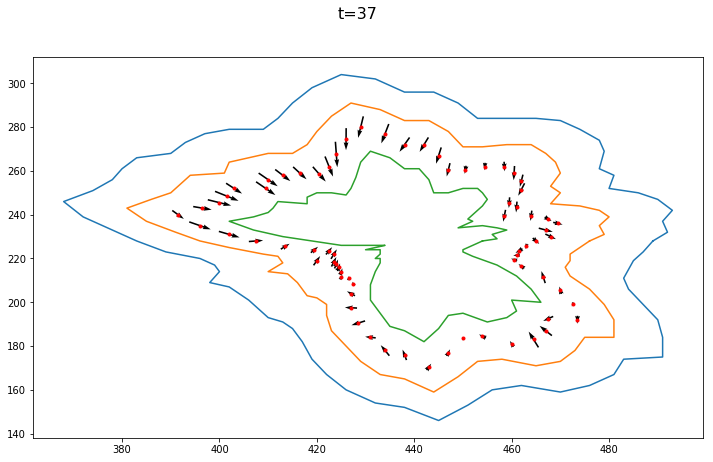

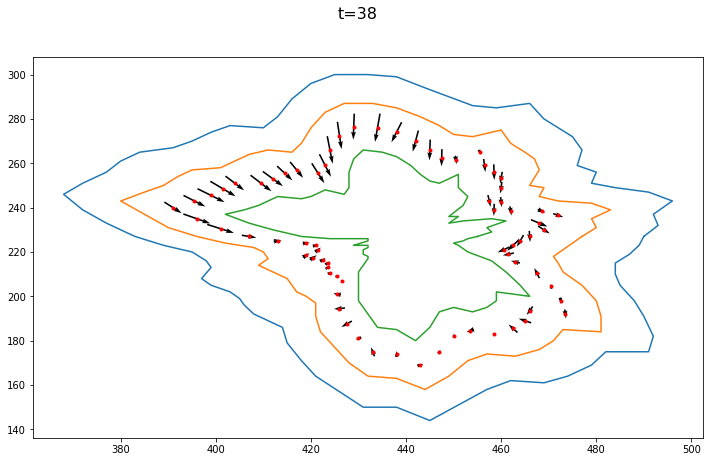

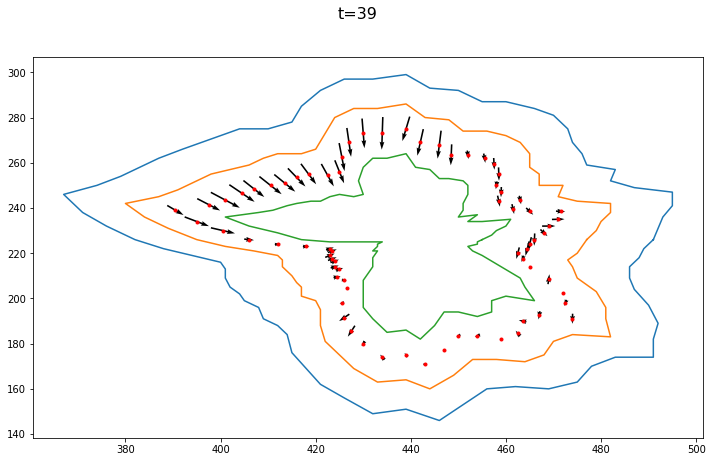

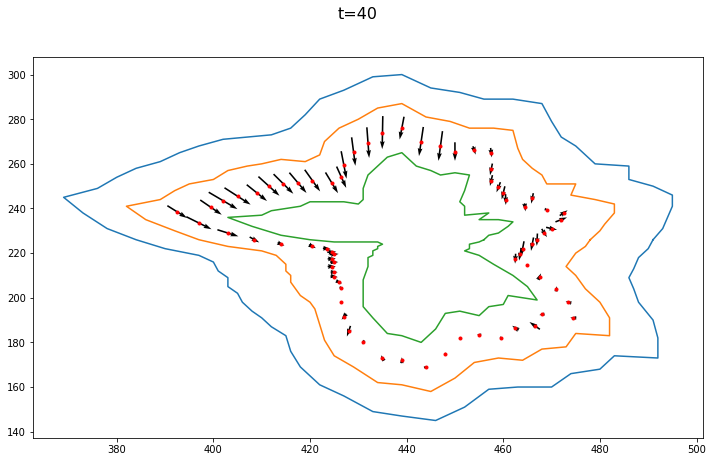

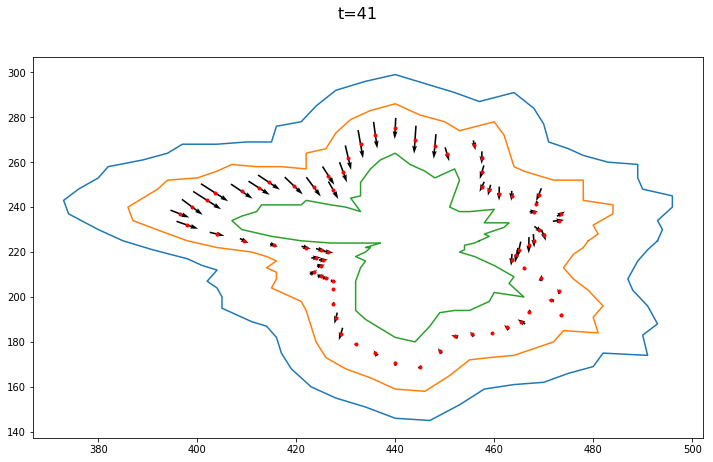

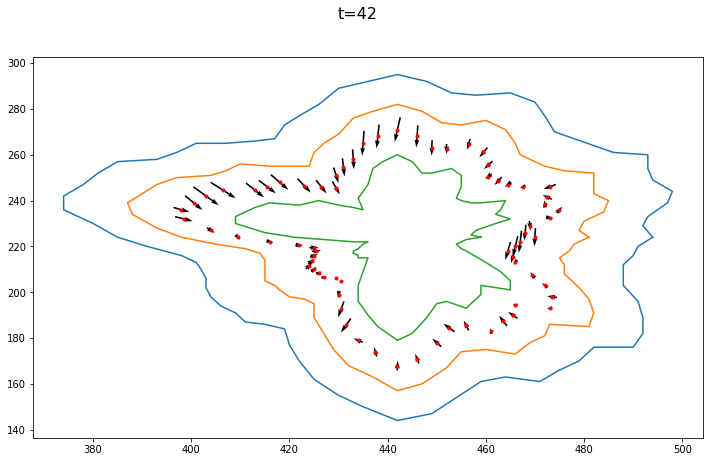

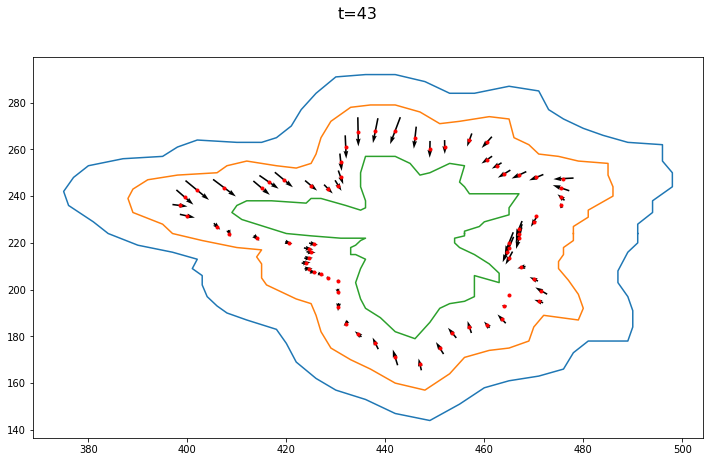

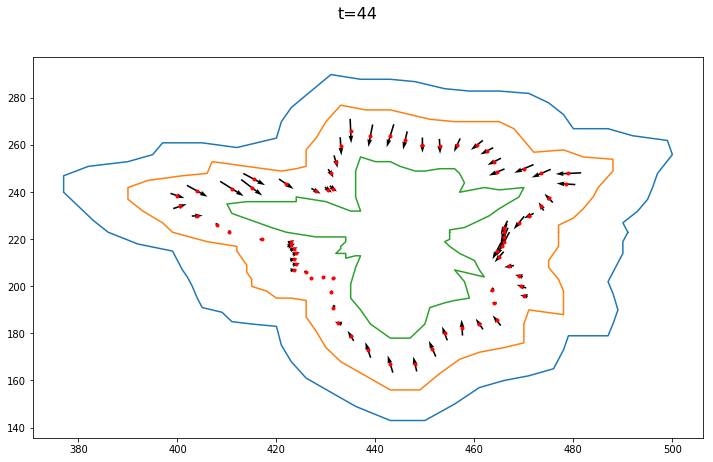

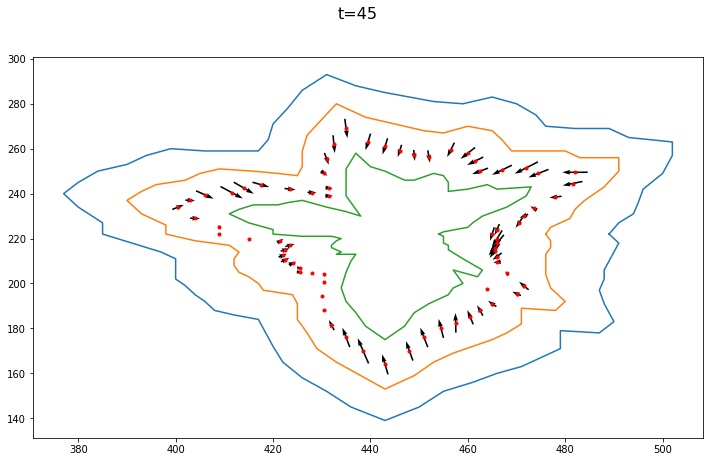

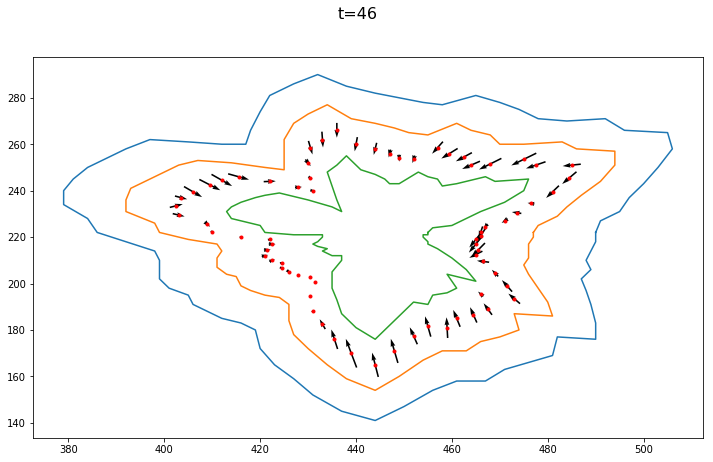

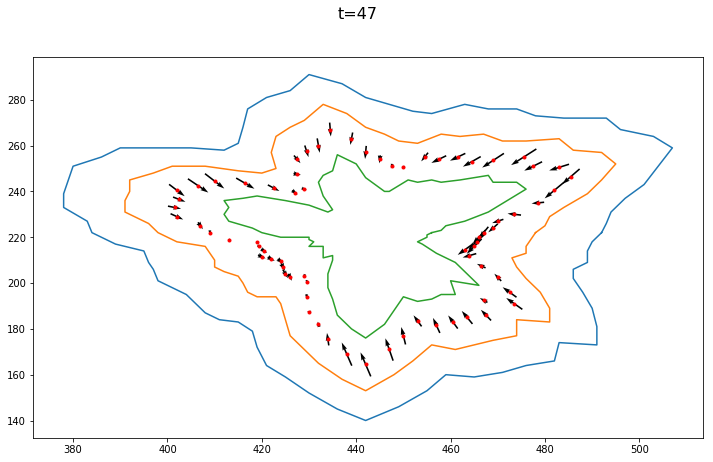

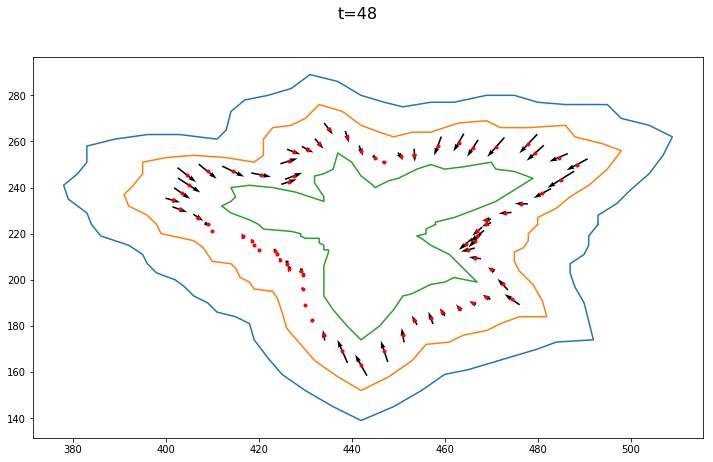

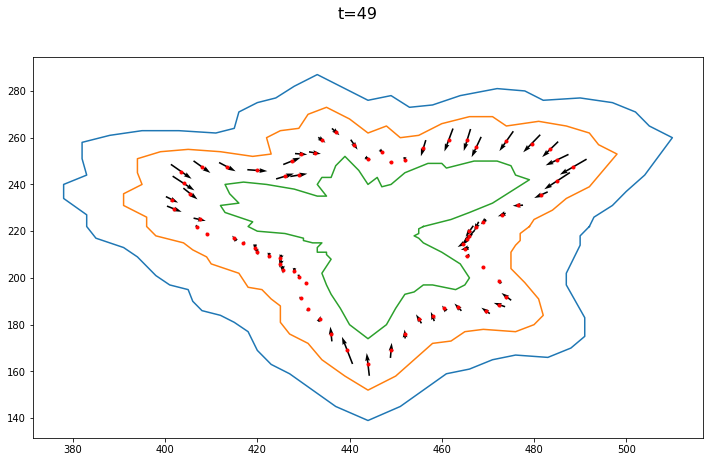

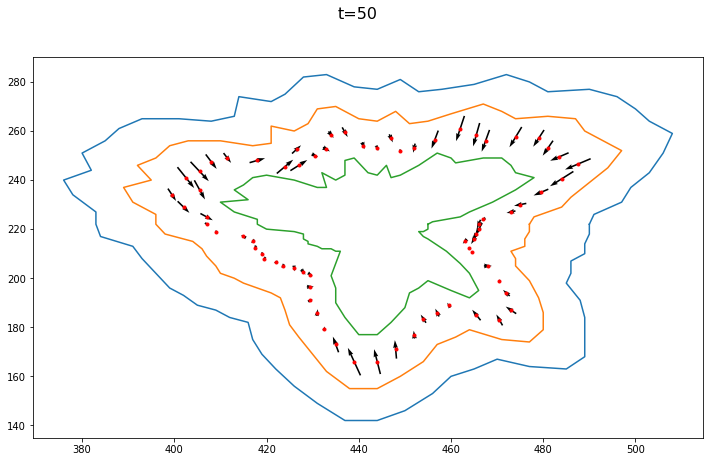

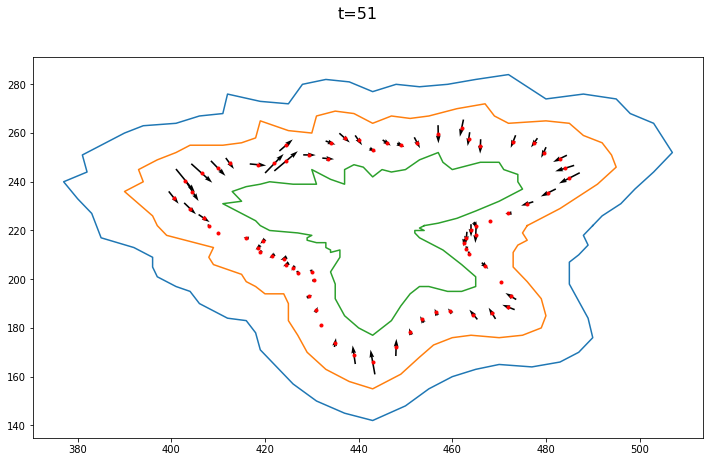

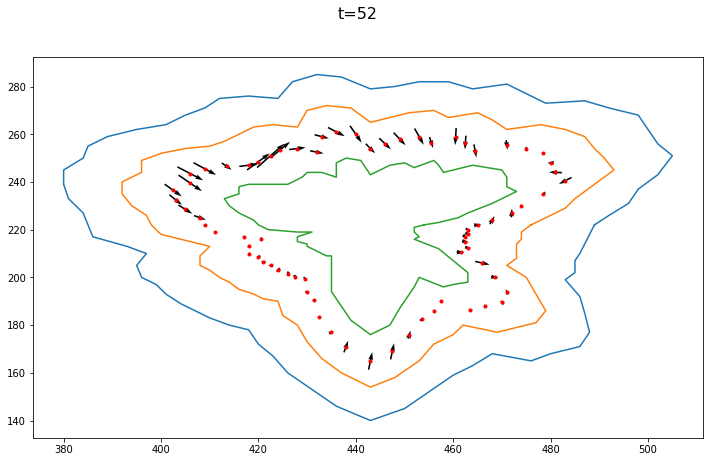

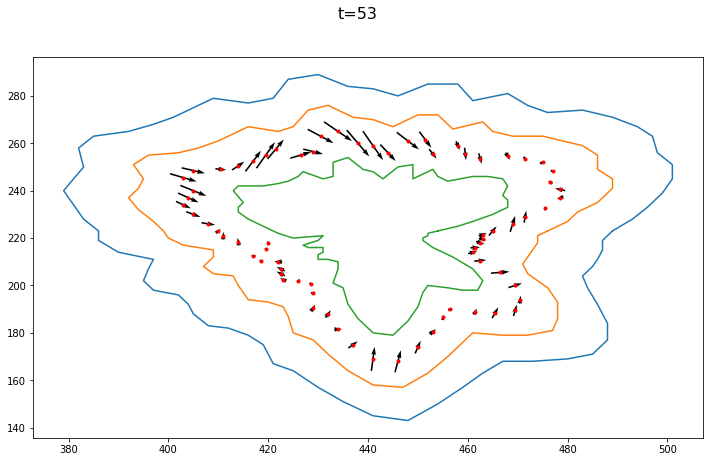

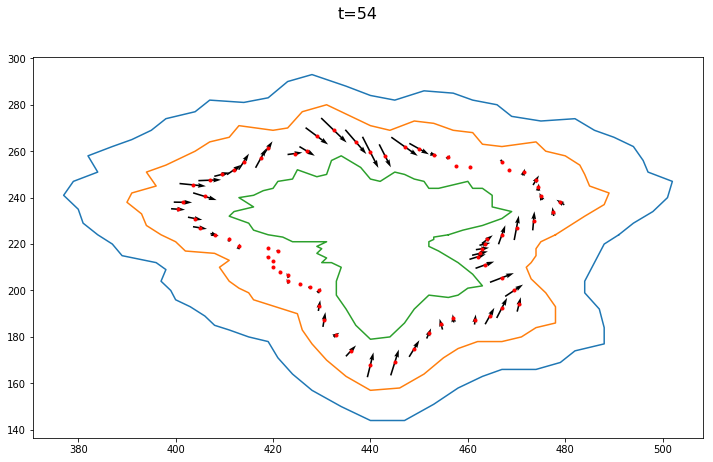

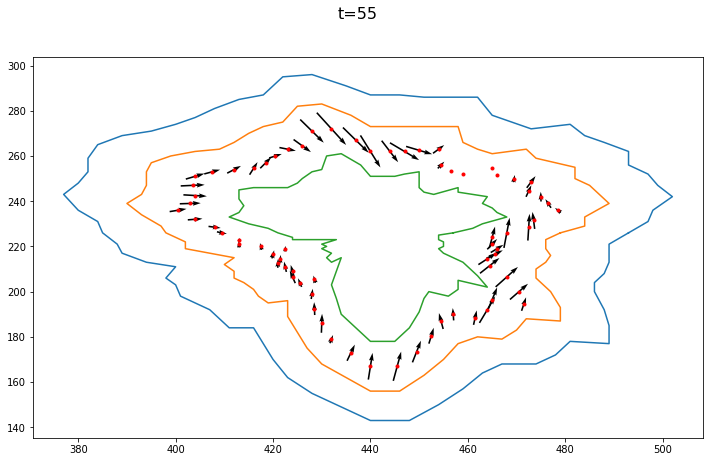

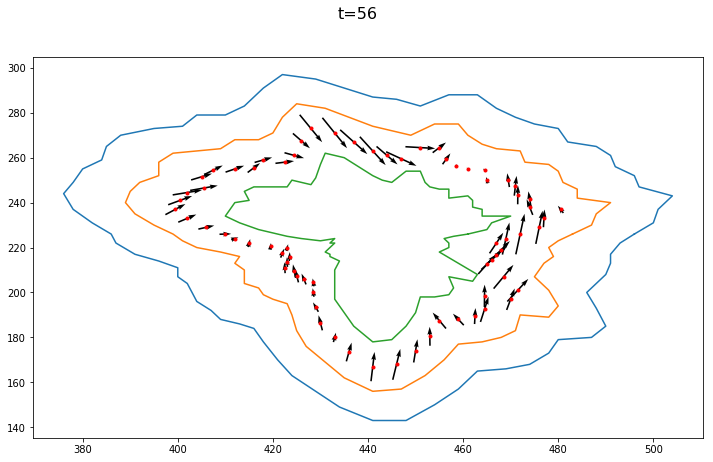

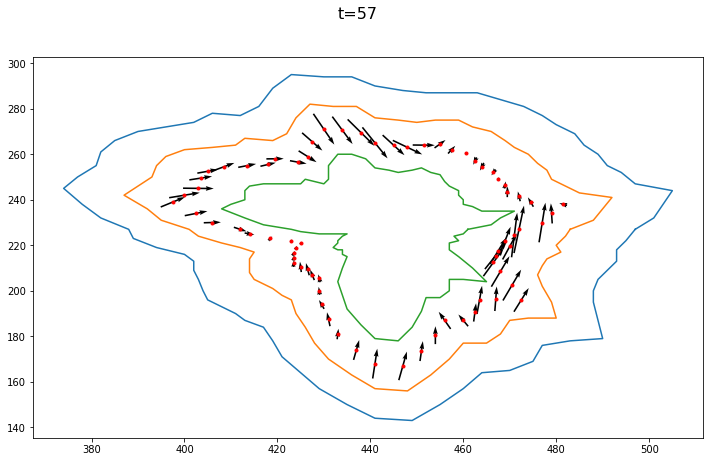

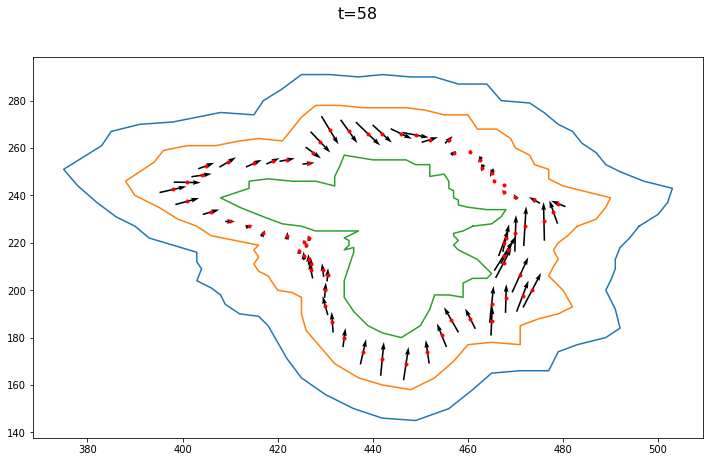

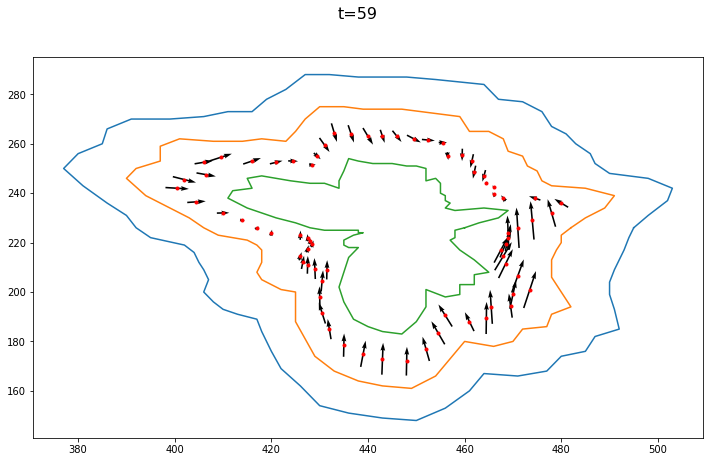

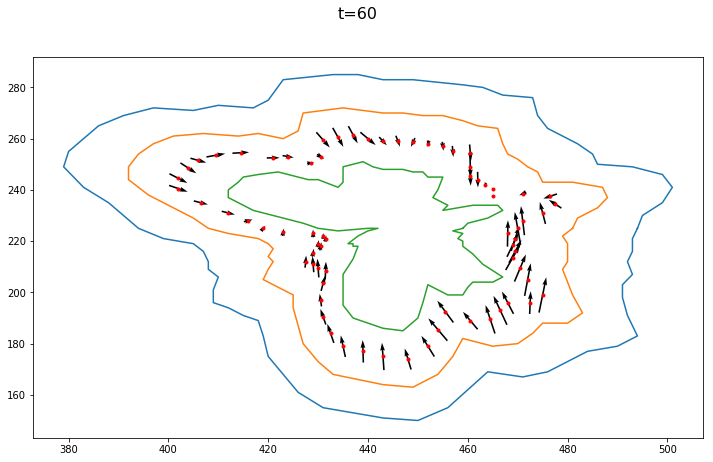

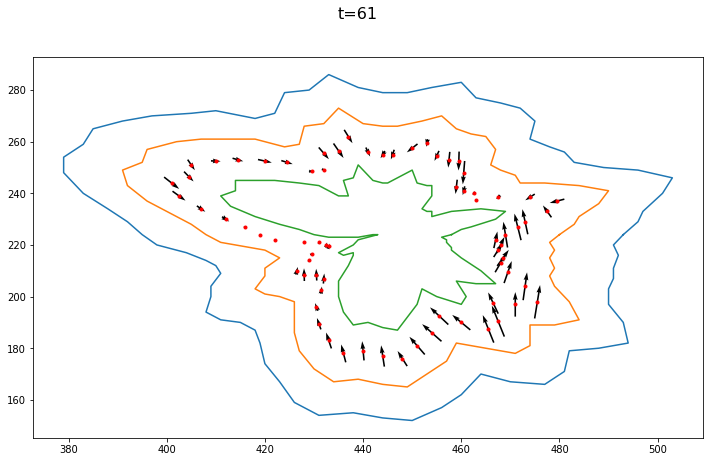

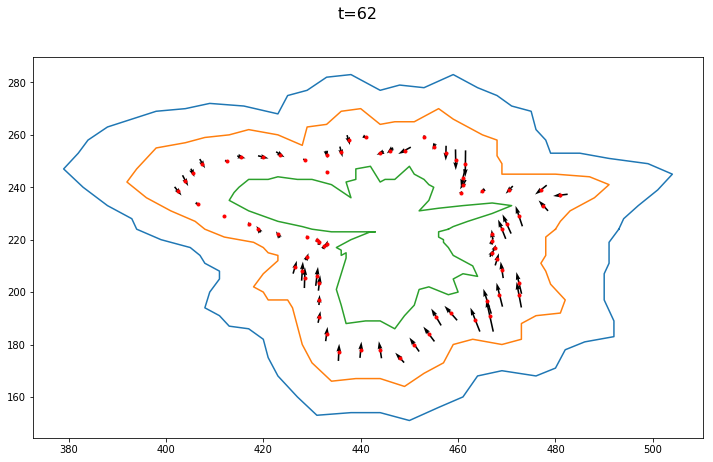

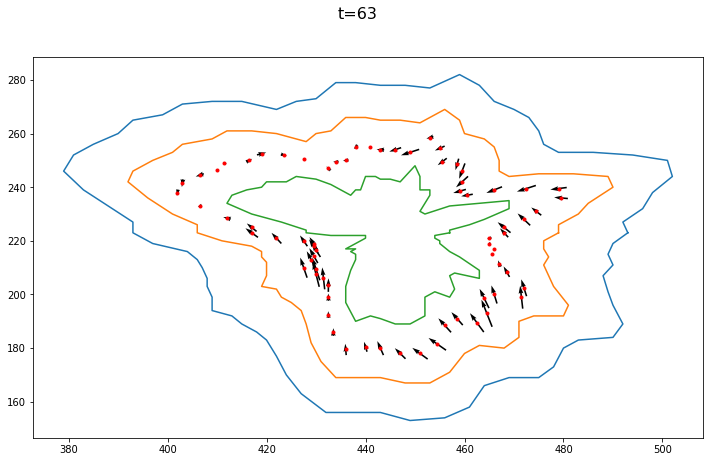

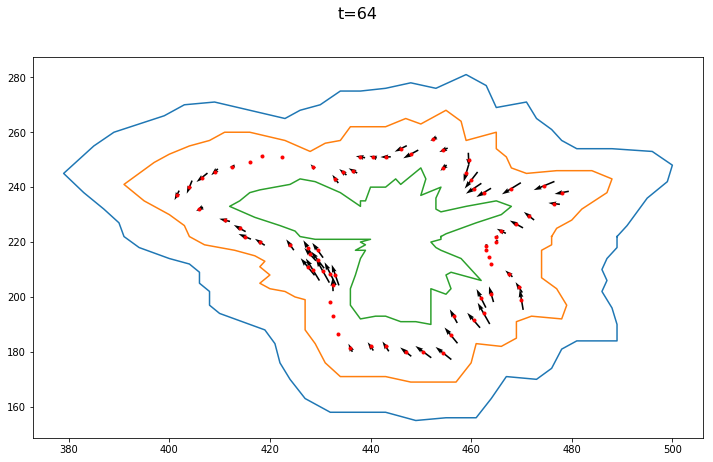

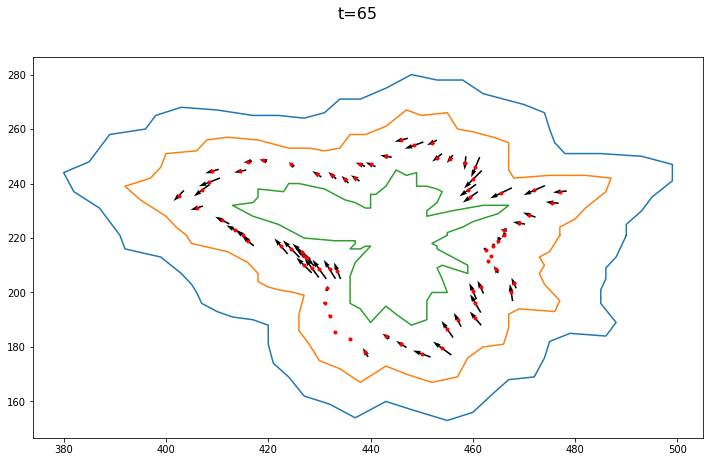

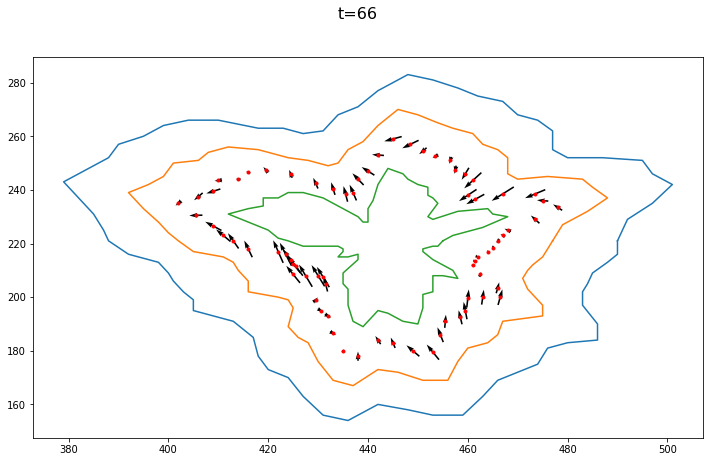

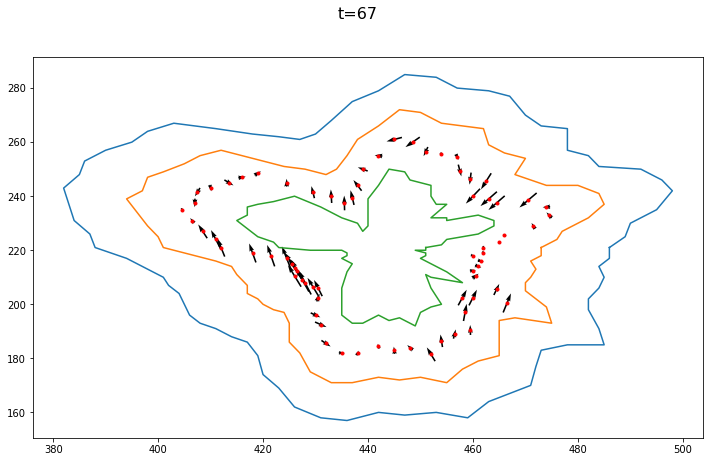

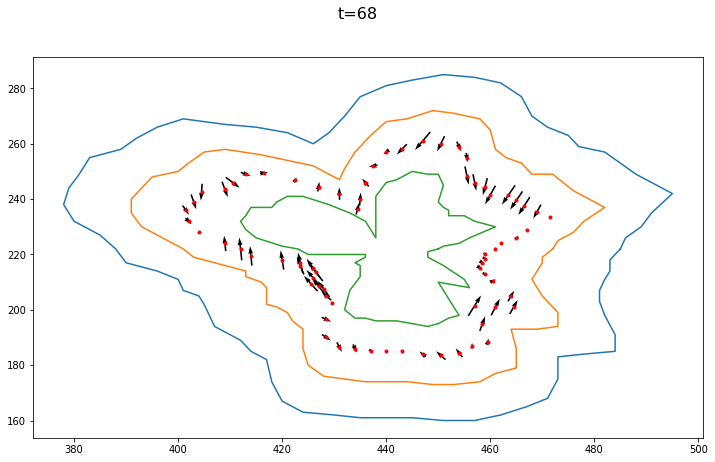

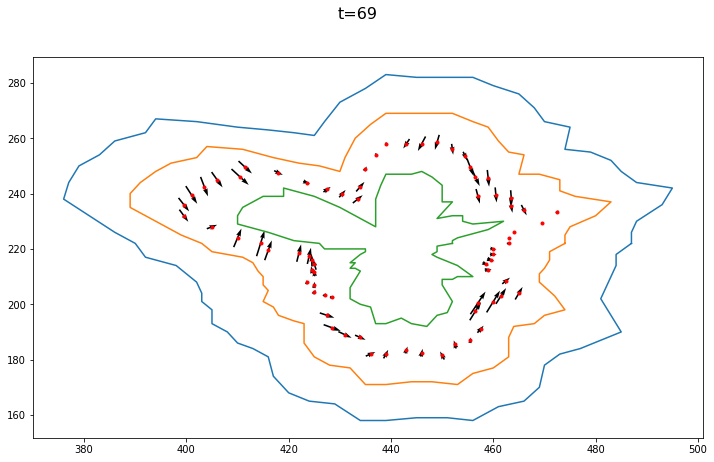

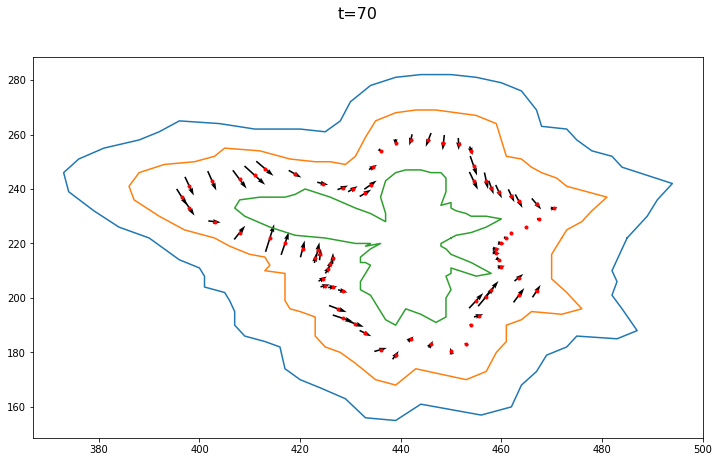

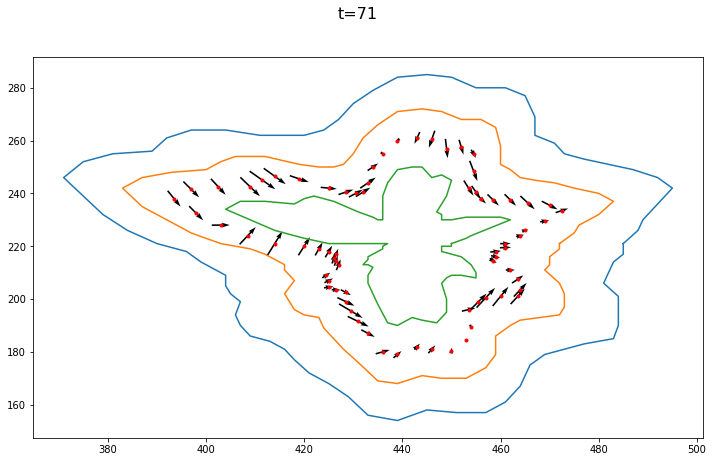

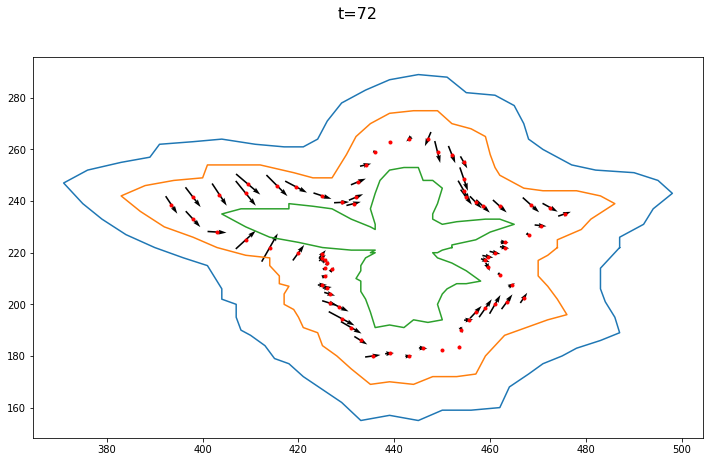

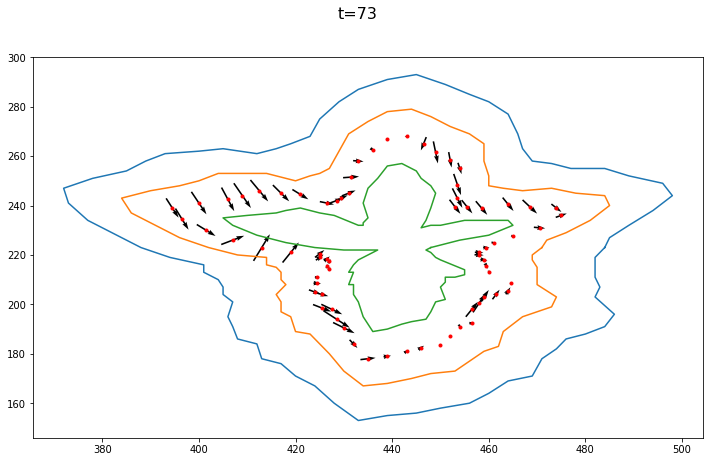

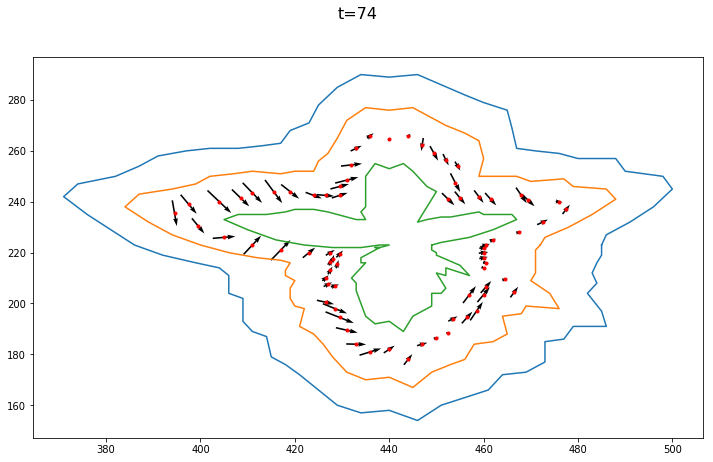

In [40]:
# Plotting 

average_projected_length_list = []
projected_flow_dict = {} # Each key stores projected flows for all rays for one time frame. 
#For example, the projected flow on ray 'r' at time 't' can be obtained by 'projected_flow_dict[t][r]'


for i in range(start_movie,end_movie,1):
    
    rayflow_x, rayflow_y = new_movie(i) # Average flows along rays
    membrane_x, membrane_y, myosin_x, myosin_y, first_interior_x, first_interior_y, last_interior_x, last_interior_y = border_comp(i)
    pylab.rcParams['figure.figsize'] = (12, 7)
    plt.suptitle('t=%d'%i, fontsize=16)
    plt.plot(membrane_x, membrane_y)
    plt.plot(first_interior_x, first_interior_y)
    plt.plot(last_interior_x, last_interior_y)
    mid_x_list = []
    mid_y_list = []
    sum_projected_length = 0
    projected_length_list = []
    
    for j in range(len(big_bresenham_dict[i])):
    
        mid_x = ((surface_coords_interior1[i][j][0]) + (surface_coords_interior_last[i][j][0]))/2
        mid_y = ((surface_coords_interior1[i][j][1]) + (surface_coords_interior_last[i][j][1]))/2
        mid_x_list.append(mid_x)
        mid_y_list.append(mid_y)
        vec_x = mid_x - moving_center[i][0]
        vec_y = mid_y - moving_center[i][1]
        projected_length = get_projected_length((vec_x, vec_y), (rayflow_x[j], rayflow_y[j])) # Finding projections along ray
        projected_length_list.append(projected_length)
        sum_projected_length+= projected_length
        
        plt.quiver(mid_x, mid_y, rayflow_x[j], rayflow_y[j], units='inches', pivot='mid', width=0.022,
               scale=1/0.2, scale_units='inches')
        
    projected_flow_dict[i] = projected_length_list 
    plt.plot(mid_x_list, mid_y_list, 'r.')
    plt.show()
    
    average_projected_length = sum_projected_length/(len(big_bresenham_dict[i]))
    average_projected_length_list.append(average_projected_length)
    

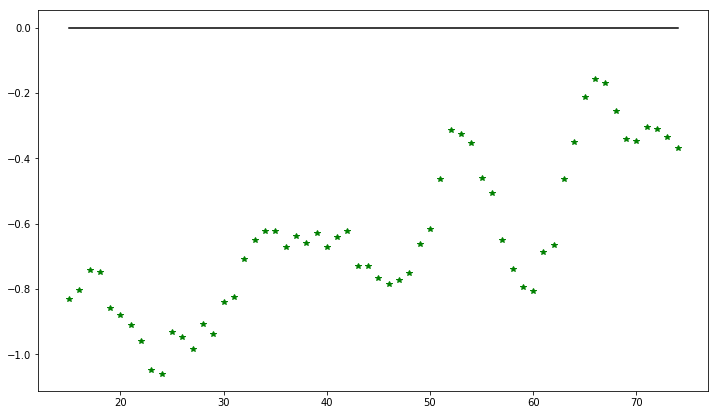

In [41]:
# The average projected flow on all rays in one time frame was computed 
#in the previous cell and this cell plots them over all time frames

t = np.arange(start_movie, end_movie, 1.)
plt.plot(t, average_projected_length_list, 'g*')
plt.plot(t, np.zeros_like(t),'k-')
plt.show()

In the following cells, we intend to see the relationship between the net flow and the net membrane movement over time. 
From the above graph, we have the net averaged flow at each time frame. Below we compute the distance by which the membrane as a whole moves in consecutive time frames.
Since this computation was already done before in the code but for clarity and ease of readibility for me, I am again reproducing the same code in the following cell and that is why I have named all the variables ending in again. For example, 'cumulative_membrane_distance_again'

In [42]:
# Computing cumulative membrane distance for all time frames

cumulative_membrane_dist_again = []

for frame in range(start_movie,end_movie,1):
    
    membrane_dist_from_center_again = 0
  
    for j in range(len(surface_coords_interior1[0])):

        dist1_again = euclid_dist(surface_coords[frame][j], moving_center[frame])
        membrane_dist_from_center_again = membrane_dist_from_center_again+dist1_again
          
    cumulative_membrane_dist_again.append(membrane_dist_from_center_again)      

In [43]:
#Computing cumulative membrane distance difference between successive time frames and plotting 

cumulative_membrane_dist_difference = []
for ix in range(1,len(cumulative_membrane_dist_again),1):
   
    cumulative_membrane_dist_difference.append((cumulative_membrane_dist_again[ix] - cumulative_membrane_dist_again[ix-1]))

In [44]:
#This cell computes Pearson Correlation Coefficient between the net flow and net membrane movement over time
corr2 = []
for start in range(0,len(cumulative_membrane_dist_difference)-15,1):
    c2,p2 = pearsonr(cumulative_membrane_dist_difference[start:], average_projected_length_list[start+1:])
    print('start: ', start, '; ','till ',len(segchannel), c2, p2)
    corr2.append(c2)

start:  0 ;  till  75 0.0803352684652 0.545283364329
start:  1 ;  till  75 0.0675772915156 0.614242570264
start:  2 ;  till  75 0.0670033170421 0.620449171231
start:  3 ;  till  75 0.061151716149 0.654358404529
start:  4 ;  till  75 0.097068941007 0.480800776073
start:  5 ;  till  75 0.124231776772 0.370772997286
start:  6 ;  till  75 0.153422429384 0.272725419438
start:  7 ;  till  75 0.196206043543 0.163299354839
start:  8 ;  till  75 0.261302490586 0.064006573965
start:  9 ;  till  75 0.255997921447 0.0727450092522
start:  10 ;  till  75 0.292676836657 0.0412731253816
start:  11 ;  till  75 0.286625143219 0.0482557200592
start:  12 ;  till  75 0.226708668953 0.125420205031
start:  13 ;  till  75 0.198486707456 0.186049878551
start:  14 ;  till  75 0.19354164553 0.202710674248
start:  15 ;  till  75 0.139965390305 0.364846261268
start:  16 ;  till  75 0.15253899303 0.328806629268
start:  17 ;  till  75 0.141992713636 0.369716837782
start:  18 ;  till  75 0.134810224608 0.400707936678

Text(0,0.5,'correlation')

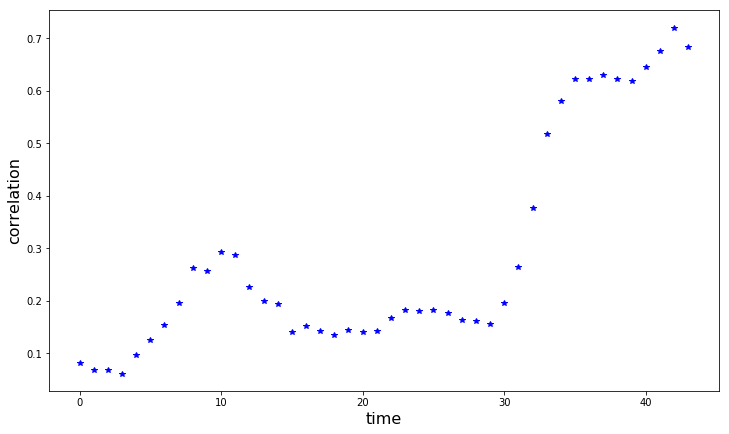

In [45]:
pyplot.plot(corr2, 'b*')
#plt.plot(t, np.zeros_like(t),'k-')
plt.xlabel('time', fontsize=16)
plt.ylabel('correlation', fontsize=16)

The above plot looks reasonable. In the beginning the correlation is not significant (even though slight negative). But after around t = 31, it increases considerably. This is in agreement to the other correlation graph obtained earlier where around the same time point, we start to see a strong correlation. 

### The following is another idea of computing and visulaizing relationship.

In [46]:
def membrane_moved_by(ray_from,ray_to):
    
    '''This function takes in the index of rays along which membrane movement over time needs to be computed.
       This function returns a dictionary called 'membrane_moved_by_dict' in which each key 
       stores the distance by which the mebrane moved along a ray with respect to the 
       previous frame for any given time point. 
       Distance by which membrane along ray 'r' moved from time 't' to time 't+1'
       is accessed by 'membrane_moved_by_dict[t][r]'

    '''
    membrane_moved_by_dict = {} 

    for frame in range(len(segchannel)-1):
        membrane_moved_by_list = []

        for j in range(ray_from,ray_to,1):
            diff1 = euclid_dist(surface_coords[frame][j], moving_center[frame])
            diff2 = euclid_dist(surface_coords[frame+1][j], moving_center[frame+1])
            membrane_moved_by = diff2-diff1
            membrane_moved_by_list.append(membrane_moved_by)

        membrane_moved_by_dict[frame] = membrane_moved_by_list
    return membrane_moved_by_dict

In [47]:
ray_from = 0
ray_to = 72
membrane_moved_by_dict = membrane_moved_by(ray_from, ray_to)

In [48]:
#In this cell, we create the two time series described above: 
#For each ray, the first series is the list called 'm_list' which stores the distance membrane moved...  
#between two successive time frames

#For each ray, the second series is the list called 'f_list' which stores the projected average flow... 
#along the ray for all time frames

cc_ray = [] # The list which stores correlation values for all the rays

for i in range(ray_from, ray_to, 1):
    m_list =[]
    f_list = []
    for j in range(time,len(segchannel)-1,1):
        m_list.append(membrane_moved_by_dict[j][i])
        f_list.append(projected_flow_dict[j+1][i])
    
    # The line below computes the correlation. The effect of computing correlations for different time
    #intervals can be seen by changing the time indices of m_list and f_list
    c_ray,p_ray = pearsonr(m_list[30:],f_list[30:])
    
    cc_ray.append(c_ray)
    
  
    ###The following commented lines can be used if one wants to...
    ###visulaize what is the behavior of membrane movement difference and projected flows on each ray
    
    
    
    #plt.suptitle('ray=%d'%i, fontsize=16)
    #plt.plot(m_list, 'b*')

    #t = np.arange(0, len(flowchannel)-time, 1.)
    #plt.plot(f_list,'y*')
    #plt.plot(t, np.zeros_like(t),'k-')
    #plt.show()

Text(0,0.5,'correlation')

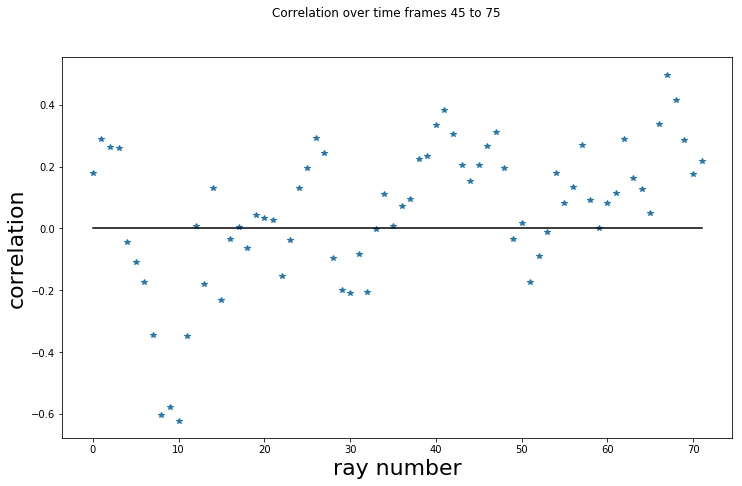

In [49]:
# Plotting the net correlations for each ray

t = np.arange(0, 72, 1.)
plt.suptitle('Correlation over time frames 45 to 75')
plt.plot(cc_ray, '*')
plt.plot(t, np.zeros_like(t),'k-')
plt.xlabel('ray number', fontsize=22)
plt.ylabel('correlation', fontsize=22)

### So far it is good, but the following ideas are the ones which did not quite work well. 

In [50]:
#In this cell, we create the two time series described above: 
#For each time point, the first series is the list called 'm_series' which stores the distance membrane moved...  
#along all rays

#For each time point, the second series is the list called 'f_series' which stores the projected average flow... 
#along all rays 

time_correlation = []
for frame in range(start_movie,end_movie-1,1):
    m_series = []
    f_series = []
    for j in range(72):
        m_series.append(membrane_moved_by_dict[frame][j])
        f_series.append(projected_flow_dict[frame+1][j])
 
    t_corr, t_p = pearsonr(m_series[30:], f_series[30:])
    time_correlation.append(t_corr)
    

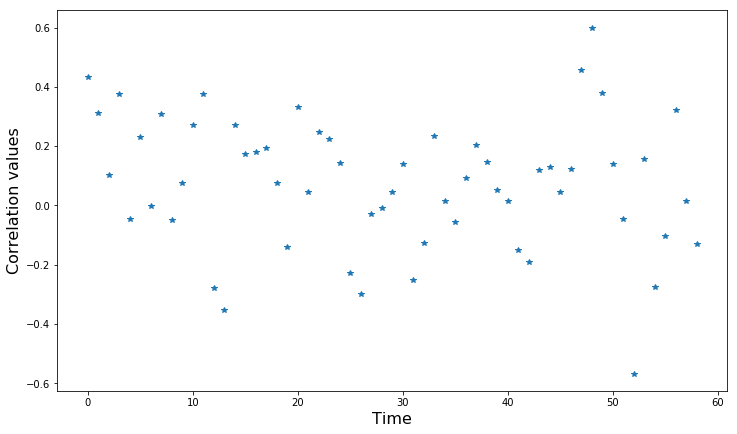

In [51]:
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Correlation values', fontsize = 16)
plt.plot(time_correlation, '*')
plt.show()

# In the figure below, each * represents a correlation value. 
#The correlation has been computed over all rays. 
#Each * denotes correlation between average projected flows on all rays and distance moved by membrane on all rays

The graph above prompted me to see the statistical behavior of average projected flows. 

The following function computes the mean, standard deviation and median of the average projected flow vectors along all rays(columns) for any given time interval. 

In [52]:
mean_flow = []
stddev_flow = []
median_flow = []

In [53]:
def avg_proj_flow_plot(frame_start, frame_end):
    frame = frame_start
    
    while (frame <= frame_end):
        
        flow_mean = np.mean(projected_flow_dict[frame])
        mean_flow.append(flow_mean)
        flow_stddev = np.std(projected_flow_dict[frame])
        stddev_flow.append(flow_stddev)
        flow_median = np.median(projected_flow_dict[frame])
        median_flow.append(flow_median)
        frame+= 1

In [54]:
avg_proj_flow_plot(time, 73)

In [55]:
print('standard deviation:',stddev_flow)
print('Mean flow:', mean_flow)
print('Median flow:', median_flow)

standard deviation: [0.7683568007104028, 0.64867007776647456, 0.63413635254459888, 0.5978389556259468, 0.53268012267179721, 0.55886584371554338, 0.61434191279556238, 0.62010839952267938, 0.5035039636549612, 0.51578389273742165, 0.53403807442938311, 0.69985521132491479, 0.65152961086100236, 0.67557982464015875, 0.74816097403258375, 0.76214970435867846, 0.76543358035982856, 0.7411130430948073, 0.65283129154762265, 0.56401375099003548, 0.52546582927436358, 0.48735582051333143, 0.61648572008523617, 0.77411141385755433, 0.87413257171005054, 0.85055486362503596, 0.77922175495319224, 0.64889800881238369, 0.57263541320453359, 0.52559952841241531, 0.47066045985023341, 0.50898737741629185, 0.55842569966301847, 0.62167334261500218, 0.65801766176574727, 0.6374787602747517, 0.62449148008226629, 0.6191087322423201, 0.73894429877287027, 0.77112009862259179, 0.79863079441733675, 0.83611858481863965, 0.77871700943759903, 0.74293391208247517, 0.62869759185848495, 0.57410339823705892, 0.54423458125609603

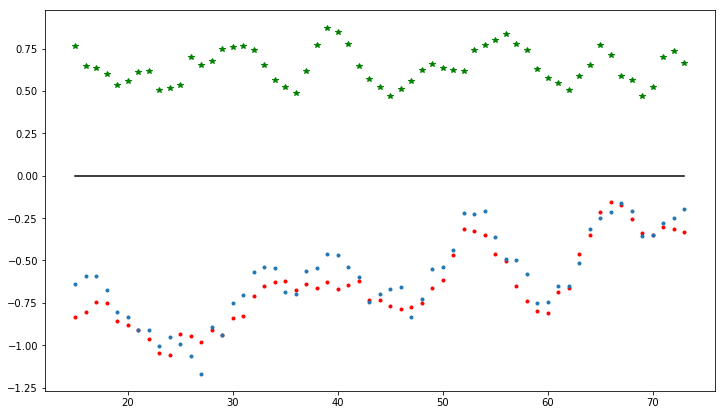

In [56]:
## Plots the mean of the average project flows on all rays. Does the same for standard deviation and median

t = np.arange(time, 74, 1.)
plt.plot(t, stddev_flow, 'g*')
plt.plot(t, mean_flow, 'r.')
plt.plot(t, median_flow, '.')
plt.plot(t, np.zeros_like(t),'k-')
plt.show()

# # Below I am plotting another experiment. Along each ray, I will average the flow for an interval in time (time averaging of flows along ray). Then, I will project the averaged flow on the ray and that way I will generate new flows along the rays for each time frame. Then I will plot the graph from last experiment. This is done in order to see if averaging in time along ray makes a difference.

In [57]:
def flow_avg_along_ray (time_avg_interval):
    
    ''' Computes the average of flows along each ray over the number of time frames specified by time_avg_interval.
        This function returns two flow dictionaries (along x and y axes) where each key in the dictionary stores 
        flow along each ray averaged over time_avg_interval for one time frame.
        For example, big_flow_x_dict[0][3] gives the averaged flow on ray 3 for time 0.
        The frames are averaged only in forward direction in time. So, with time_avg_interval =3,
        the flows in frames t =0, t=1 and t =2 are averaged along each ray and this creates the flow for time point t=0.
    '''
    
    big_flow_x_dict = {}
    big_flow_y_dict = {}
    
    for i in range(len(segchannel)-time_avg_interval):
        
        flow_x_avg_along_ray = []
        flow_y_avg_along_ray = []

        for ray in range(72):

            flow_x_at_interest_points = []
            flow_y_at_interest_points = []

            for t in range(time_avg_interval):
                bbd = big_bresenham_dict[i+t][ray] #interest points along a ray for a time
                bbd = np.roll(bbd,1,axis=1)
                flow_x_at_interest_points.append(flow_x_original[i+t, bbd[:,0], bbd[:,1]])
                flow_y_at_interest_points.append(flow_y_original[i+t,bbd[:,0], bbd[:,1]])


            concatX = np.concatenate(flow_x_at_interest_points)
            concatY = np.concatenate(flow_y_at_interest_points)
            flow_x_avg_along_ray.append(np.mean(concatX)) 
            flow_y_avg_along_ray.append(np.mean(concatY))
        
        big_flow_x_dict[i] = flow_x_avg_along_ray
        big_flow_y_dict[i] = flow_y_avg_along_ray
        
    return big_flow_x_dict, big_flow_y_dict

In [58]:
time_avg_interval = 40

In [59]:
## This cell is calling the function above and creating new flows along rays. Then it projects the newly computed...
## ray flows in the direction of rays. 


projected_flow_dict_another = {}
for t in range(len(segchannel)-time_avg_interval):
    
    a,b = flow_avg_along_ray(time_avg_interval)
    projected_length_list_another = []
    for j in range(len(a[t])):
    
        vec_x_another = surface_coords_interior1[t][j][0] - moving_center[t][0]
        vec_y_another = surface_coords_interior1[t][j][1] - moving_center[t][1]
        projected_length_another = get_projected_length((vec_x, vec_y), (a[t][j], b[t][j]))
        projected_length_list_another.append(projected_length_another)
        
    projected_flow_dict_another[t] = projected_length_list_another

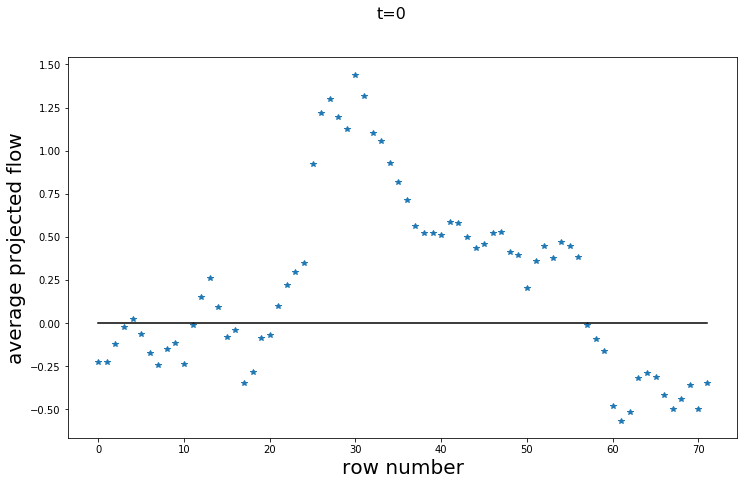

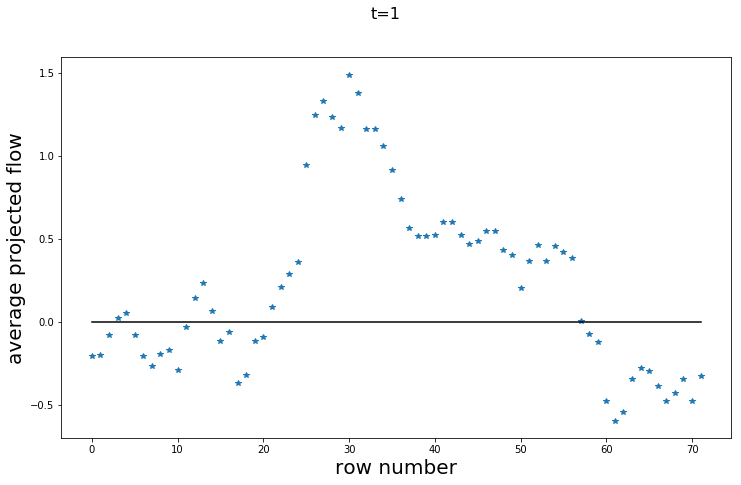

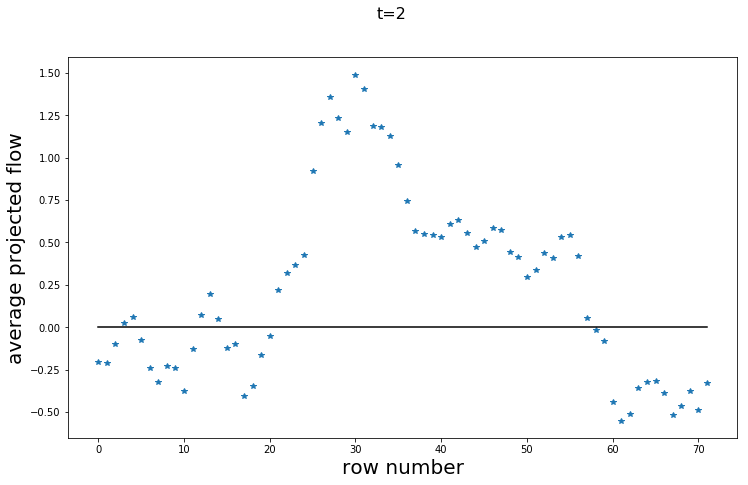

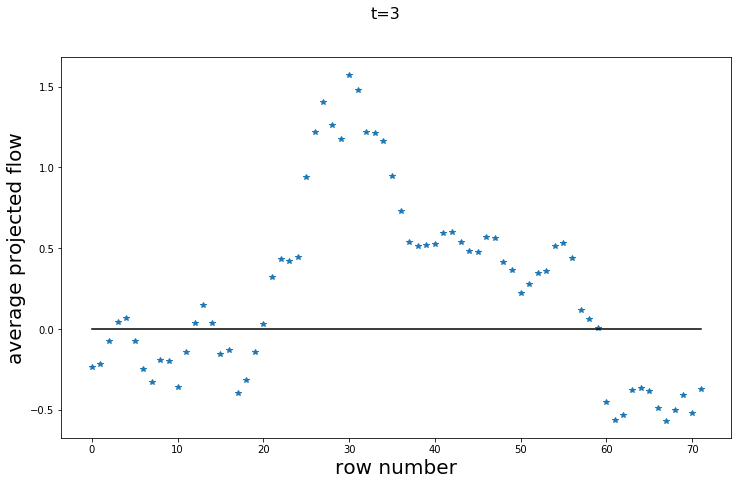

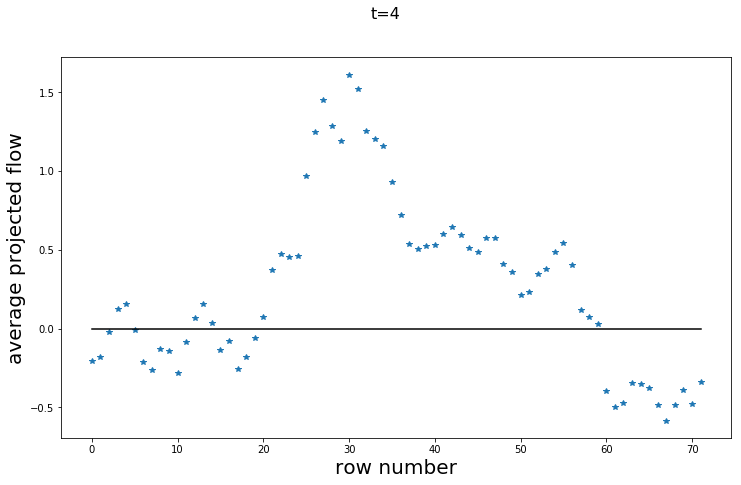

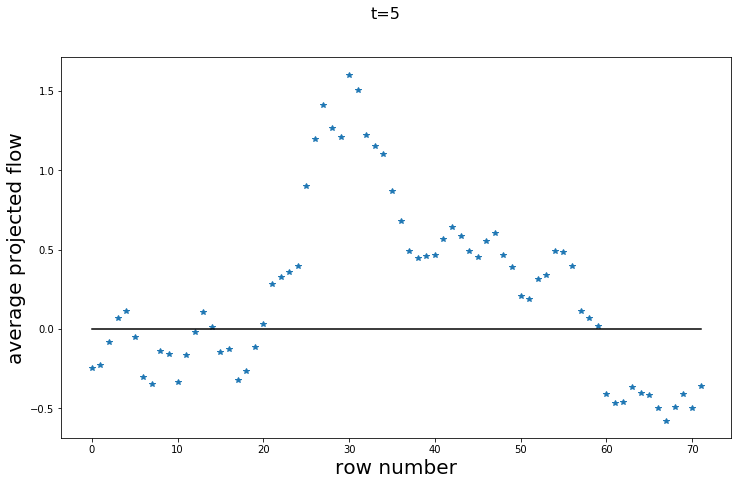

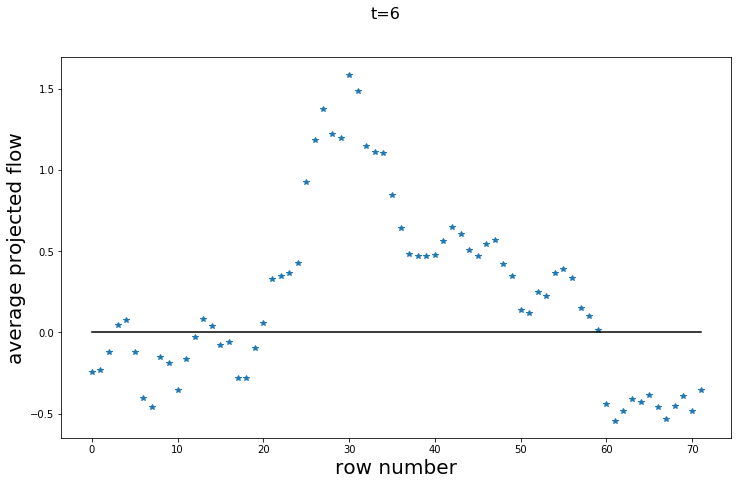

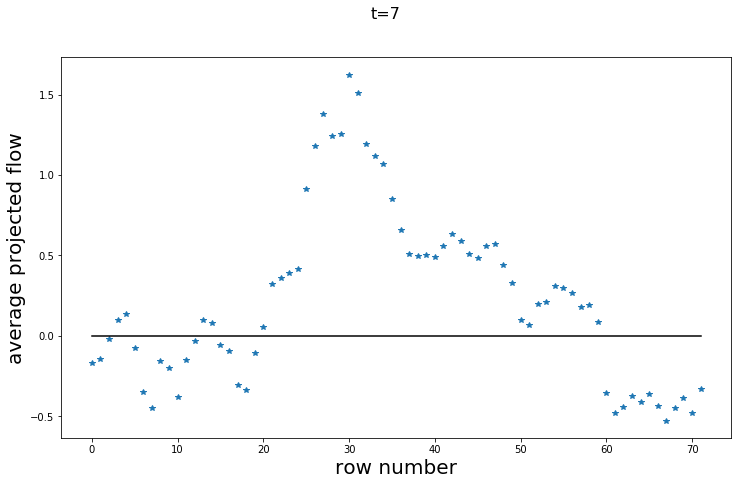

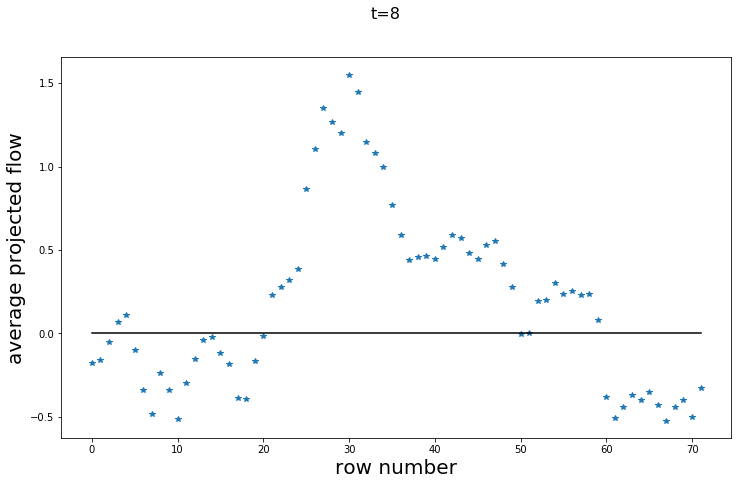

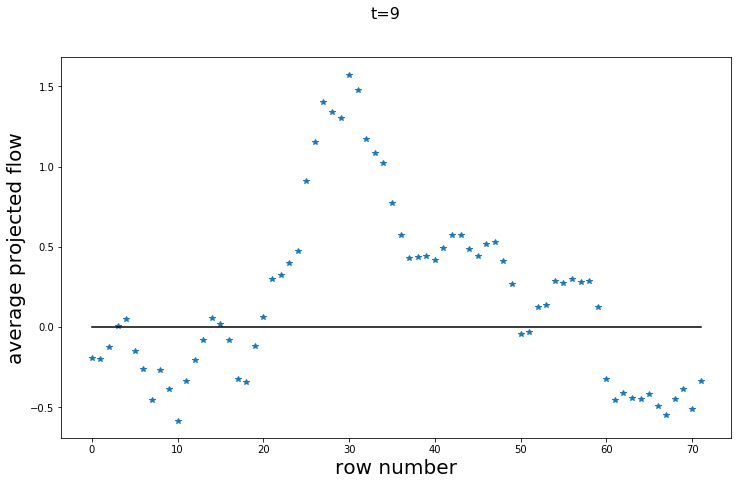

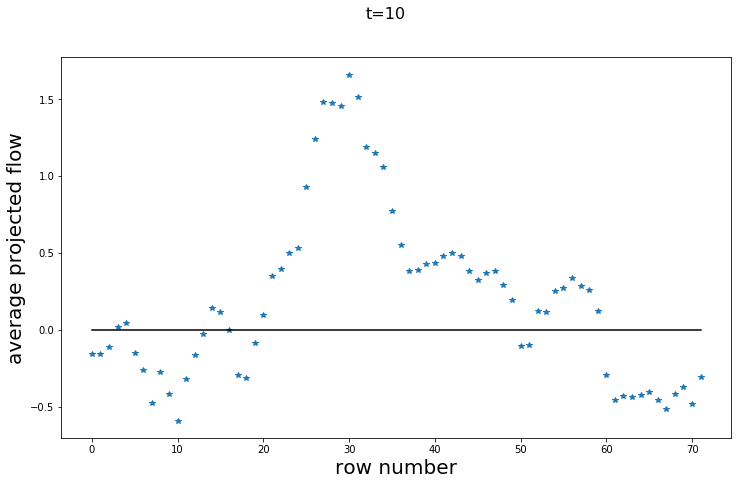

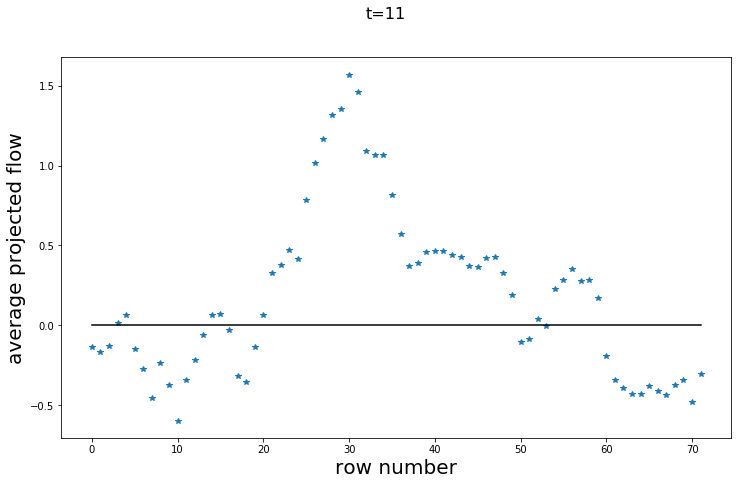

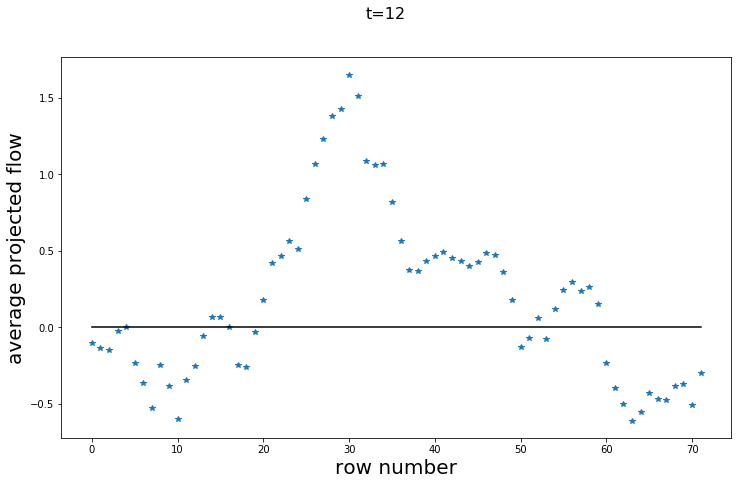

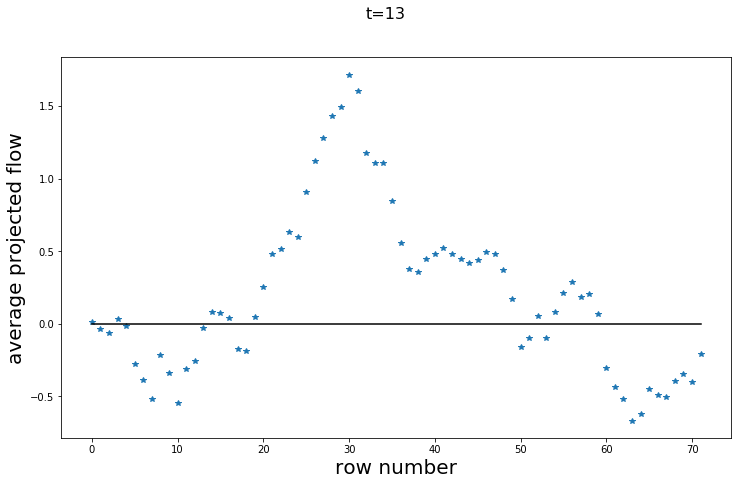

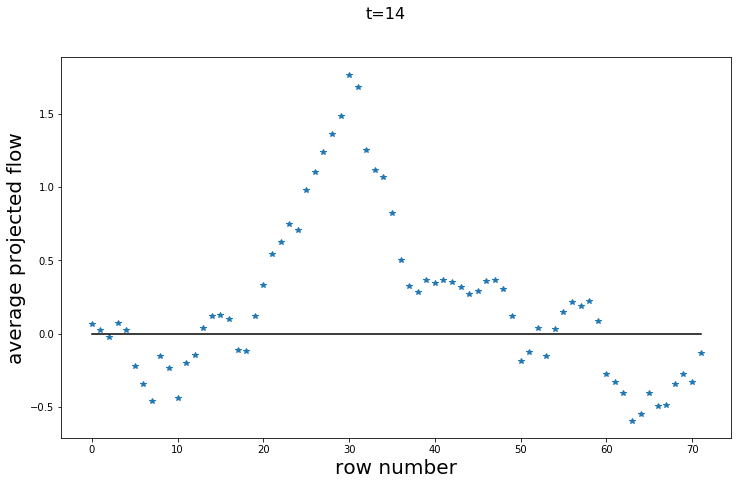

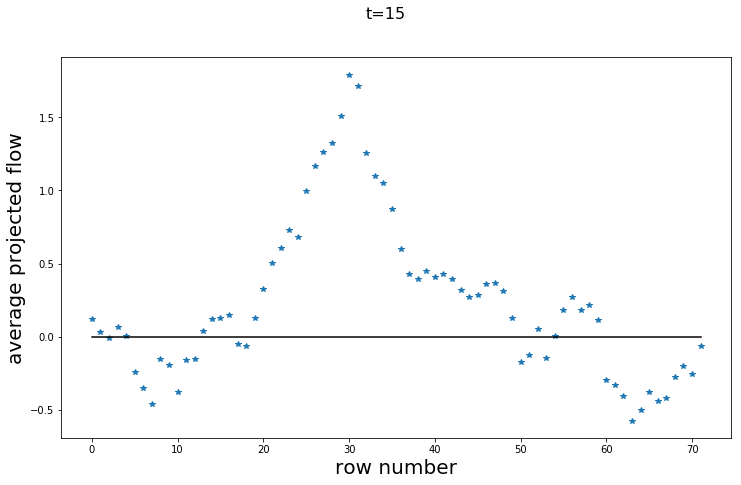

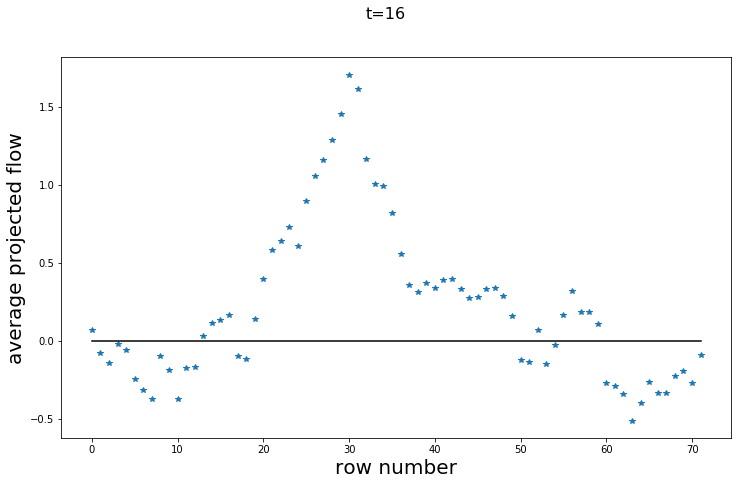

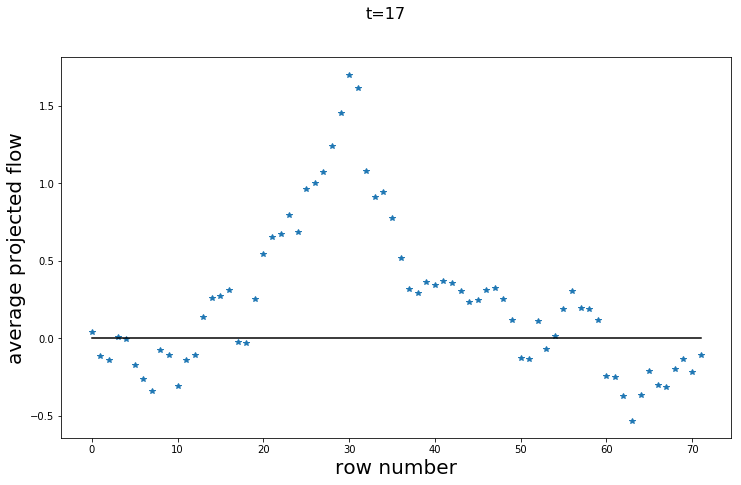

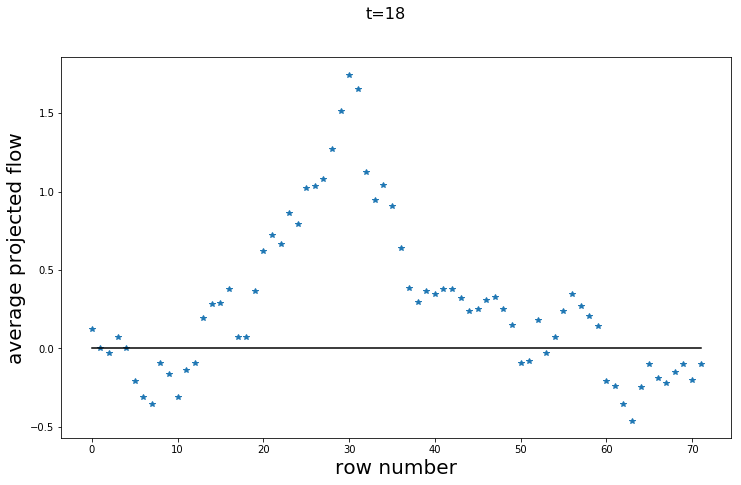

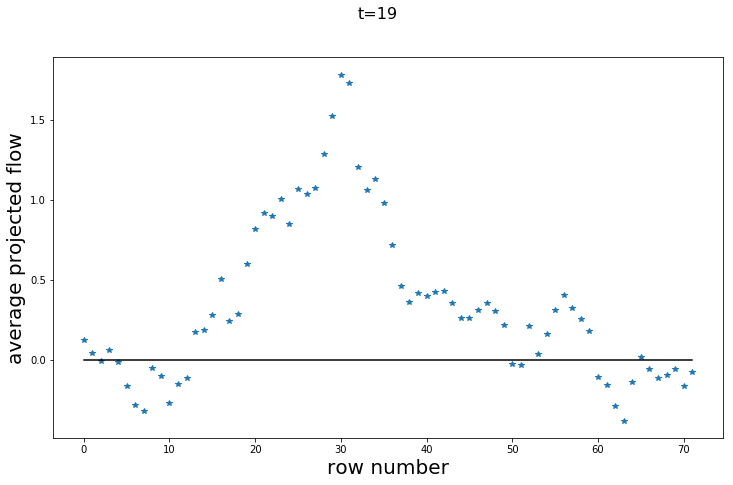

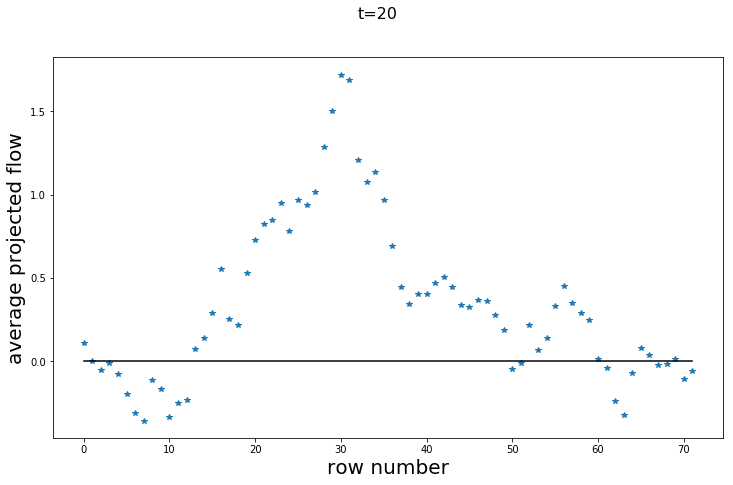

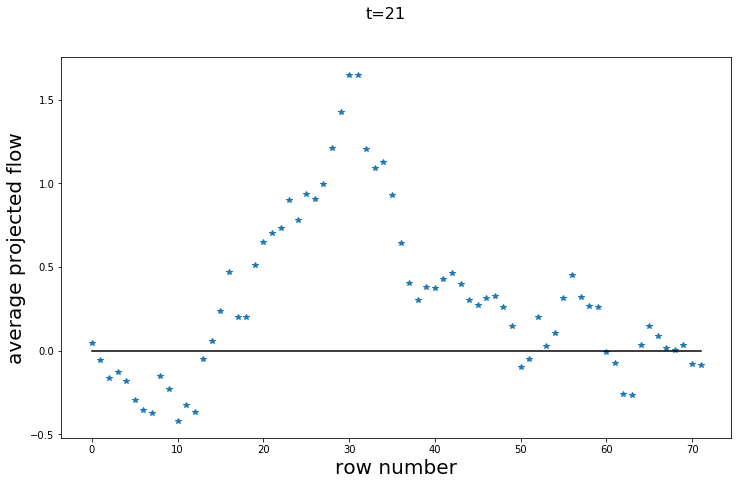

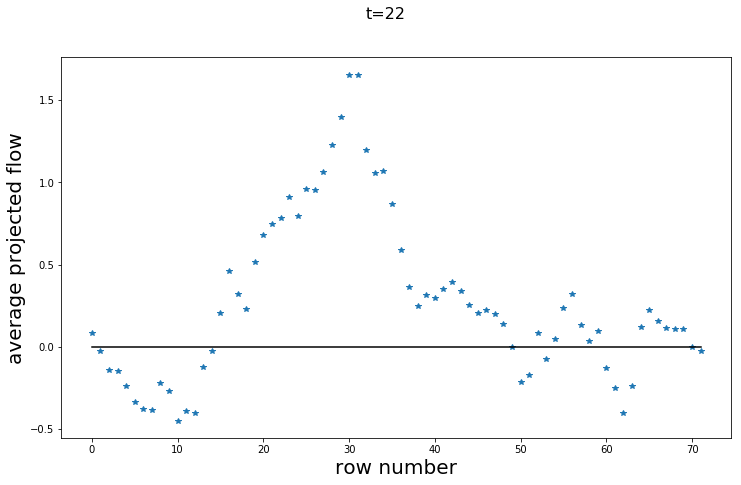

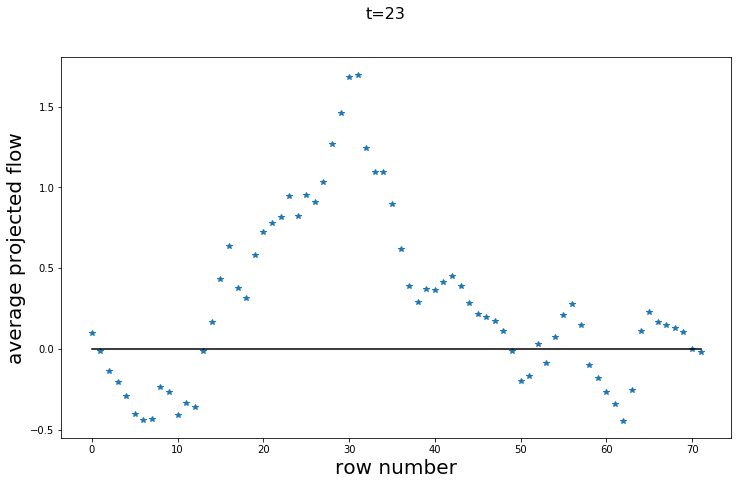

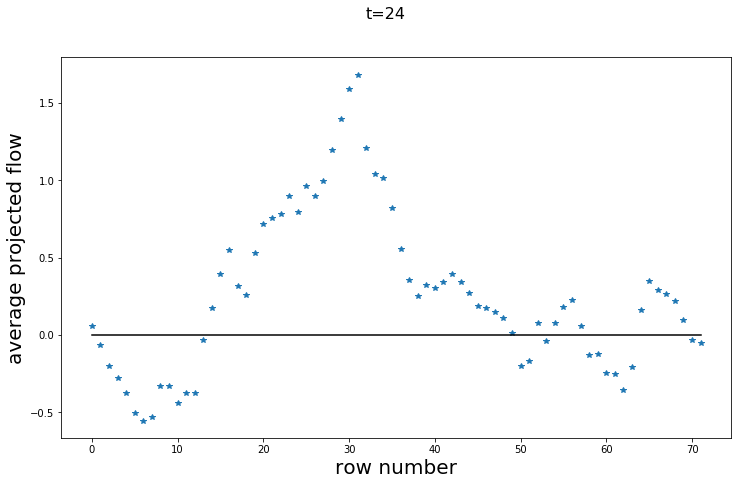

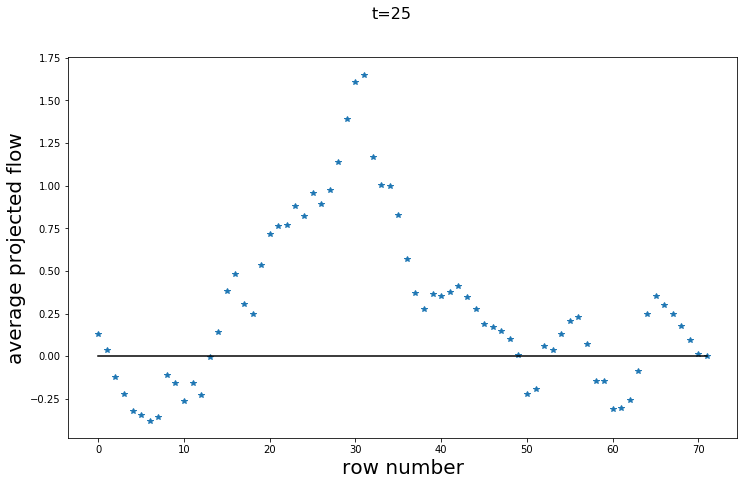

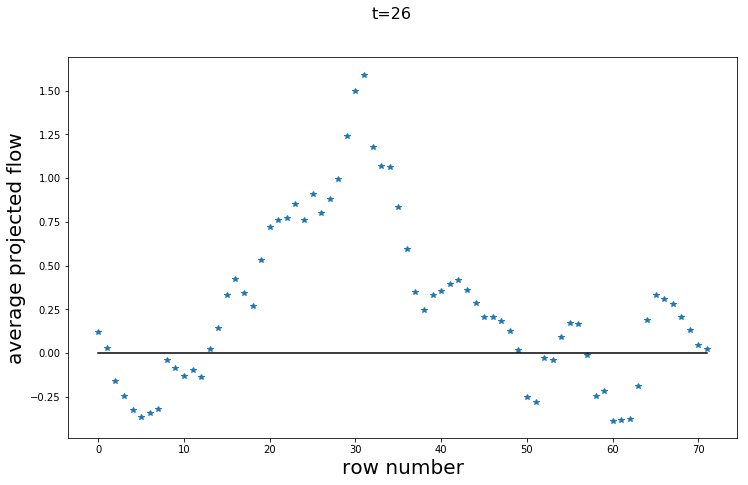

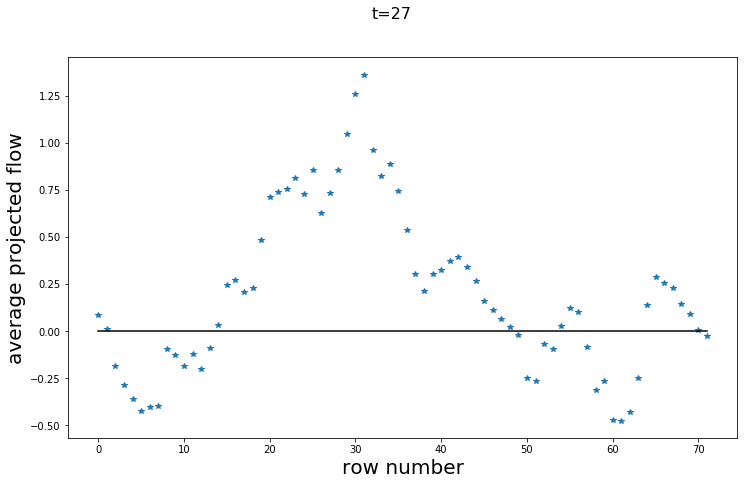

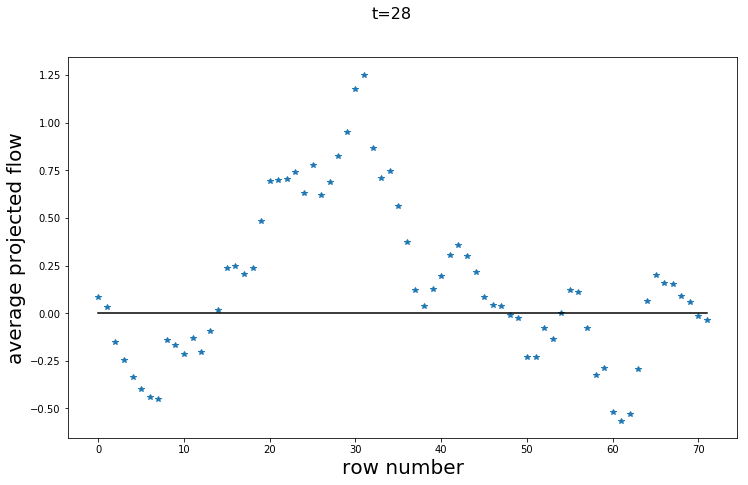

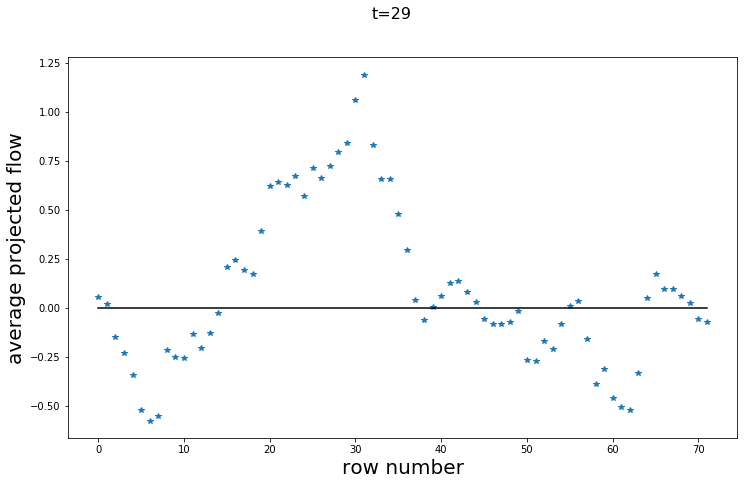

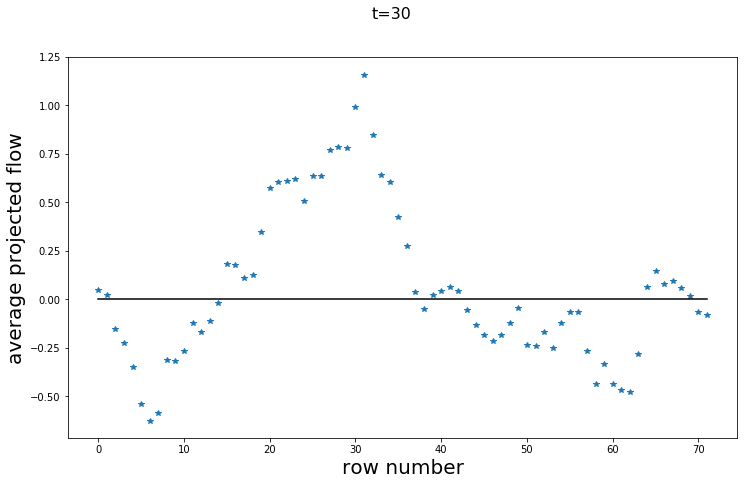

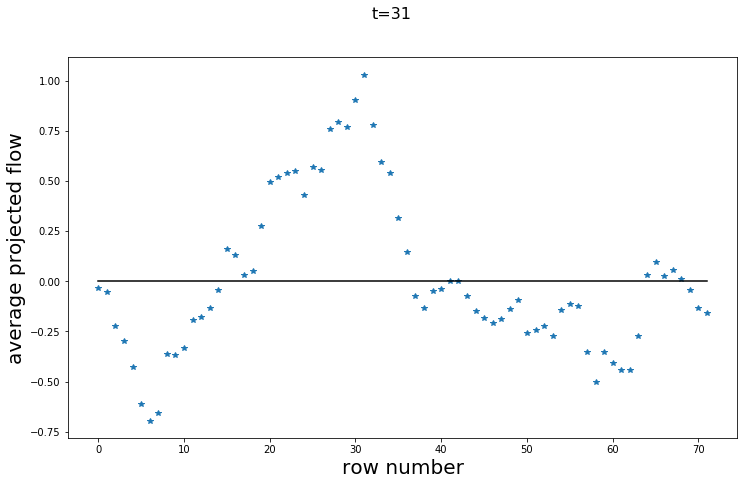

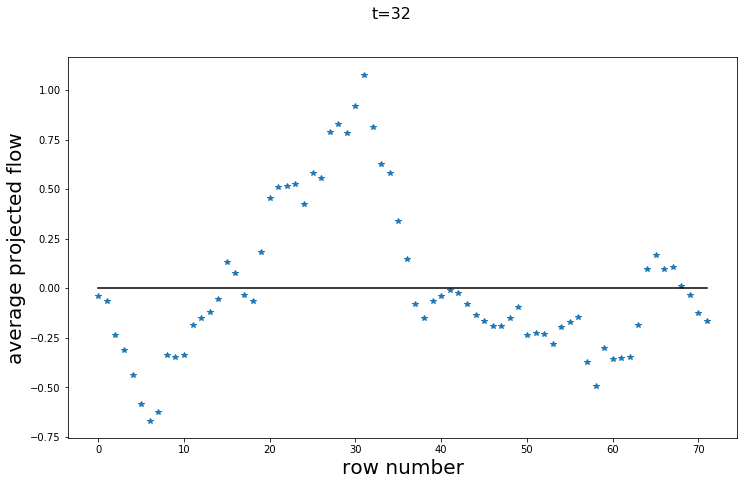

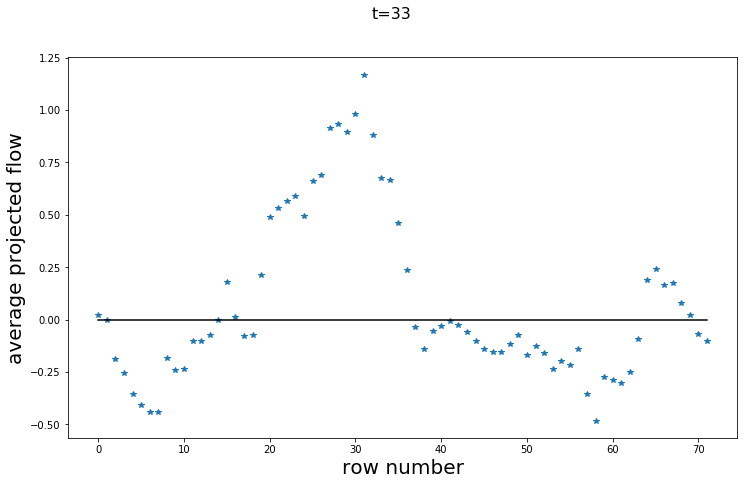

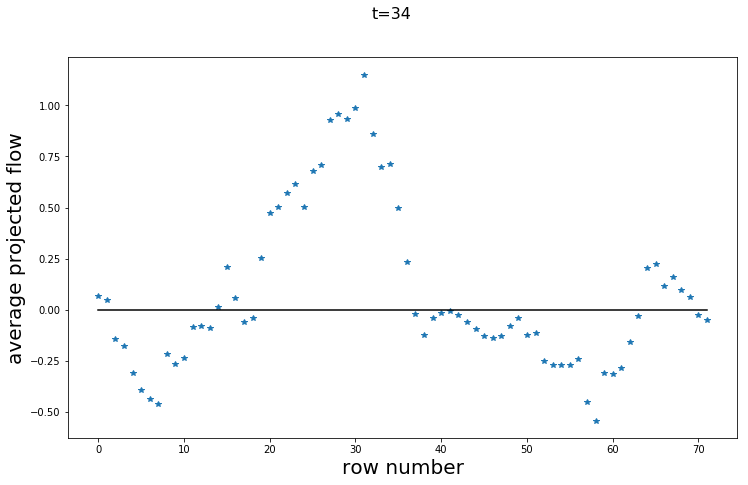

In [60]:
## Plotting the average projected flow vs the row index

t = np.arange(0, 72, 1.)
for i in range(len(projected_flow_dict_another)):
    plt.suptitle('t=%d'%i, fontsize=16)
    plt.xlabel('row number', fontsize = 20)
    plt.ylabel('average projected flow', fontsize = 20)
    plt.plot(projected_flow_dict_another[i],'*')
    plt.plot(t, np.zeros_like(t),'k-')
    plt.show()

In [61]:
##Here we are plotting the correlation between the membrane moved along all rays between successive time frames...
##and the average projected flows on all rays for each time frame. 
##This means that for each time, we have two series.
##1) The first series is the list of the distances by which the membrane moved over successive time frames along all rays
##2) The second series is the average projected flow over all rays.



time_correlation_another = []

for frame in range(start_movie,len(segchannel)-time_avg_interval-1,1):
    
    m_series_another = []
    f_series_another = []
    
    for j in range(72):
        
        m_series_another.append(membrane_moved_by_dict[frame][j])
        f_series_another.append(projected_flow_dict_another[frame+1][j])
        
    t_corr_another, t_p_another = pearsonr(m_series_another, f_series_another)
    time_correlation_another.append(t_corr_another)
    print(t_corr_another)

-0.212088033651
0.192060271958
-0.163207619672
-0.185849741677
-0.0411303896565
-0.116293423144
-0.0201131769506
0.106949841655
0.0141053823934
-0.0739453139475
-0.217341832657
0.09200335229
0.00313943293597
0.182873213828
0.0103326911435
0.220189938356
0.383120706021
-0.137901340491
0.0946050391285


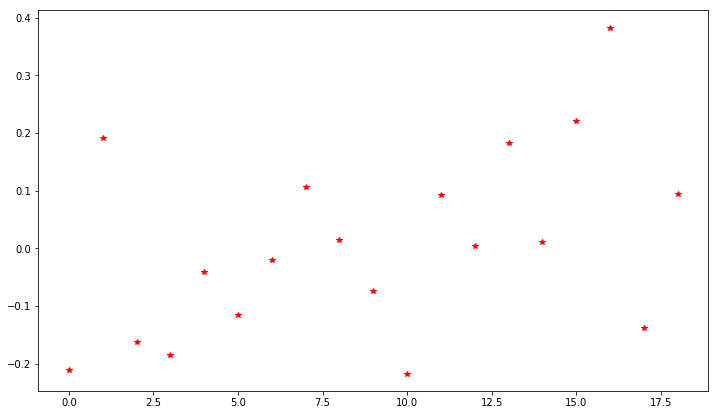

In [64]:
plt.plot(time_correlation_another,'r*')
plt.show()